In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from rbf import KernelRetrieval
import scipy
import pickle
import pandas as pd

In [2]:
def Bias(est_mat, true_val):
    a = est_mat - true_val
    return np.mean(a, axis=0, where=~(np.isinf(a) | np.isnan(a)))

def RMSE(est_mat, true_val):
    a = (est_mat - true_val)**2
    return np.sqrt(np.mean(a, axis=0, where=~(np.isinf(a) | np.isnan(a))))

def CovProb(est_mat, sd_mat, true_val, alpha=0.95):
    low_ci = est_mat + sd_mat*scipy.stats.norm.ppf((1 - alpha)/2)
    up_ci = est_mat - sd_mat*scipy.stats.norm.ppf((1 - alpha)/2)
    return np.mean((low_ci <= true_val) & (up_ci >= true_val), axis=0)

In [3]:
rho = 0.5  # correlation between adjacent Xs
d = 20   # Dimension of the confounding variables
n = 2000

Sigma = np.zeros((d,d)) + np.eye(d)
for i in range(d):
    for j in range(i+1, d):
        if (j < i+2) or (j > i+d-2):
            Sigma[i,j] = rho
            Sigma[j,i] = rho
sig = 1

job_id = 123
np.random.seed(job_id)
# Data generating process
X_sim = np.random.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n)
nu = np.random.randn(n)
eps = np.random.randn(n)

theta = 1/(np.linspace(1, d, d)**2)

T_sim = scipy.stats.norm.cdf(3*np.dot(X_sim, theta)) + 3*nu/4 - 1/2
Y_sim = 1.2*T_sim + T_sim**2 + T_sim*X_sim[:,0] + 1.2*np.dot(X_sim, theta) + eps*np.sqrt(0.5+ scipy.stats.norm.cdf(X_sim[:,0]))
X_dat = np.column_stack([T_sim, X_sim])

t_qry = np.linspace(-2, 2, 81)

## Dose-Response Curve Estimation

### Bias Comparison for $m(t)$

In [ ]:
reg = 'NN'
fac_lst = [0.75, 1, 1.25, 1.5, 2, 4]
cond_type = ['true', 'kde', 'reg']
t_qry = np.linspace(-2, 2, 81)
m_true = 1.2*t_qry + t_qry**2
n = 2000

model_lst = ['knn', 'nn']

for fac in fac_lst:
    for cond in cond_type:
        with open('./Syn_Results/Simulation2_m_est_'+str(reg)+'_h'+str(fac)+'_condmod_'+str(cond)+'_n_'+str(n)+'_nobnd.dat', "rb") as file:
            m_ra5_lst, m_ra1_lst, m_ipw5_lst, m_ipw1_lst, \
            m_dr5_lst, sd_dr5_lst, m_dr1_lst, sd_dr1_lst = pickle.load(file)
        
        # Bias
        m_ra1_bias = Bias(np.array(m_ra1_lst), m_true)
        
        m_ipw1_bias = Bias(np.array(m_ipw1_lst), m_true)
        
        m_dr1_bias = Bias(np.array(m_dr1_lst), m_true)
        
        # RMSE
        m_ra1_rmse = RMSE(np.array(m_ra1_lst), m_true)
        
        m_ipw1_rmse = RMSE(np.array(m_ipw1_lst), m_true)
        
        m_dr1_rmse = RMSE(np.array(m_dr1_lst), m_true)
        
        # Coverage
        m_dr1_cov = CovProb(np.array(m_dr1_lst), np.array(sd_dr1_lst), m_true, alpha=0.95)
        
        if cond == 'true':
            res_bias = np.column_stack([t_qry, m_ra1_bias, m_ipw1_bias, m_dr1_bias])
            
            res_rmse = np.column_stack([t_qry, m_ra1_rmse, m_ipw1_rmse, m_dr1_rmse])
            res_cov = np.column_stack([t_qry, m_dr1_cov])
        else:
            res_bias = np.column_stack([res_bias, m_ipw1_bias, m_dr1_bias])
            res_rmse = np.column_stack([res_rmse, m_ipw1_rmse, m_dr1_rmse])
            res_cov = np.column_stack([res_cov, m_dr1_cov])
                                           
    
    res_bias1 = pd.DataFrame(res_bias)
    res_bias1.columns = ['Query point', 'RA (L=1)', 'IPW (true, L=1)', 'DR (true, L=1)',
                       'IPW (KDE, L=1)', 'DR (KDE, L=1)', 'IPW (reg, L=1)', 'DR (reg, L=1)']
    
    res_rmse1 = pd.DataFrame(res_rmse)
    res_rmse1.columns = ['Query point', 'RA (L=1)', 'IPW (true, L=1)', 'DR (true, L=1)', 'IPW (KDE, L=1)',
                         'DR (KDE, L=1)', 'IPW (reg, L=1)', 'DR (reg, L=1)']
    
    res_cov1 = pd.DataFrame(res_cov)
    res_cov1.columns = ['Query point', 'DR (true, L=1)', 'DR (KDE, L=1)', 'DR (reg, L=1)']
    
    for ml in model_lst:
        with open('./Syn_Results/Sim2_Replicate_est_'+str(ml)+'_h'+str(fac)+'_n_'+str(n)+'.dat', "rb") as file:
            m_est1_lst, m_std1_lst, theta_est1_lst, theta_std1_lst,\
            m_est5_lst, m_std5_lst, theta_est5_lst, theta_std5_lst = pickle.load(file)
        
        m1_bias = Bias(np.array(m_est1_lst), m_true)
        
        m1_rmse = RMSE(np.array(m_est1_lst), m_true)
        
        m1_cov = CovProb(np.array(m_est1_lst), np.array(m_std1_lst), m_true, alpha=0.95)
        
        if ml == 'knn':
            res_bias_rep = np.column_stack([t_qry, m1_bias])
            res_rmse_rep = np.column_stack([t_qry, m1_rmse])
            res_cov_rep = np.column_stack([t_qry, m1_cov])
        else:
            res_bias_rep = np.column_stack([res_bias_rep, m1_bias])
            res_rmse_rep = np.column_stack([res_rmse_rep, m1_rmse])
            res_cov_rep = np.column_stack([res_cov_rep, m1_cov])
        
    res_bias1_rep = pd.DataFrame(res_bias_rep)
    res_bias1_rep.columns = ['Query point', 'KL2020 KNN (L=1)', 'KL2020 NN (L=1)']
    
    res_rmse1_rep = pd.DataFrame(res_rmse_rep)
    res_rmse1_rep.columns = ['Query point', 'KL2020 KNN (L=1)', 'KL2020 NN (L=1)']
    
    res_cov1_rep = pd.DataFrame(res_cov_rep)
    res_cov1_rep.columns = ['Query point', 'KL2020 KNN (L=1)', 'KL2020 NN (L=1)']
    
    plt.figure(figsize=(6,4))
    for i in range(res_bias1.shape[1] - 1):
        plt.plot(t_qry, res_bias1.iloc[:,i+1], label=res_bias1.columns[i+1])
    for i in range(res_bias1_rep.shape[1] - 1):
        plt.plot(t_qry, res_bias1_rep.iloc[:,i+1], label=res_bias1_rep.columns[i+1], color='black')
    plt.ylim([-2, 2])
    plt.xlabel('Query points')
    plt.ylabel(r'Bias for $m(t)$')
    plt.title(r'$h=$'+str(fac)+'$\hat{\sigma}_T n^{-1/5}$')
    plt.legend(bbox_to_anchor=(1, 1))
    
plt.show()

### RMSE for $m(t)$

In [ ]:
reg = 'NN'
fac_lst = [0.75, 1, 1.25, 1.5, 2, 4]
cond_type = ['true', 'kde', 'reg']
t_qry = np.linspace(-2, 2, 81)
m_true = 1.2*t_qry + t_qry**2
n = 2000

model_lst = ['knn', 'nn']

for fac in fac_lst:
    for cond in cond_type:
        with open('./Syn_Results/Simulation2_m_est_'+str(reg)+'_h'+str(fac)+'_condmod_'+str(cond)+'_n_'+str(n)+'_nobnd.dat', "rb") as file:
            m_ra5_lst, m_ra1_lst, m_ipw5_lst, m_ipw1_lst, \
            m_dr5_lst, sd_dr5_lst, m_dr1_lst, sd_dr1_lst = pickle.load(file)
        
        # RMSE
        m_ra1_rmse = RMSE(np.array(m_ra1_lst), m_true)
        
        m_ipw1_rmse = RMSE(np.array(m_ipw1_lst), m_true)
        
        m_dr1_rmse = RMSE(np.array(m_dr1_lst), m_true)
        
        if cond == 'true':
            res_rmse = np.column_stack([t_qry, m_ra1_rmse, m_ipw1_rmse, m_dr1_rmse])
        else:
            res_rmse = np.column_stack([res_rmse, m_ipw1_rmse, m_dr1_rmse])
    
    res_rmse1 = pd.DataFrame(res_rmse)
    res_rmse1.columns = ['Query point', 'RA (L=1)', 'IPW (true, L=1)', 'DR (true, L=1)', 'IPW (KDE, L=1)',
                         'DR (KDE, L=1)', 'IPW (reg, L=1)', 'DR (reg, L=1)']
    
    for ml in model_lst:
        with open('./Syn_Results/Sim2_Replicate_est_'+str(ml)+'_h'+str(fac)+'_n_'+str(n)+'.dat', "rb") as file:
            m_est1_lst, m_std1_lst, theta_est1_lst, theta_std1_lst,\
            m_est5_lst, m_std5_lst, theta_est5_lst, theta_std5_lst = pickle.load(file)
        
        m1_rmse = RMSE(np.array(m_est1_lst), m_true)
        
        if ml == 'knn':
            res_rmse_rep = np.column_stack([t_qry, m1_rmse])
        else:
            res_rmse_rep = np.column_stack([res_rmse_rep, m1_rmse])
    
    res_rmse1_rep = pd.DataFrame(res_rmse_rep)
    res_rmse1_rep.columns = ['Query point', 'KL2020 KNN (L=1)', 'KL2020 NN (L=1)']
    
    plt.figure(figsize=(6,4))
    for i in range(res_rmse1.shape[1] - 1):
        plt.plot(t_qry, res_rmse1.iloc[:,i+1], label=res_rmse1.columns[i+1])
    for i in range(res_bias1_rep.shape[1] - 1):
        plt.plot(t_qry, res_rmse1_rep.iloc[:,i+1], label=res_rmse1_rep.columns[i+1], color='black')
    plt.ylim([-0.3, 2])
    plt.xlabel('Query points')
    plt.ylabel(r'RMSE for $m(t)$')
    plt.title(r'$h=$'+str(fac)+'$\hat{\sigma}_T n^{-1/5}$')
    plt.legend(bbox_to_anchor=(1, 1))
    
plt.show()

### Coverage for $m(t)$

In [ ]:
reg = 'NN'
fac_lst = [0.75, 1, 1.25, 1.5, 2, 4]
cond_type = ['true', 'kde', 'reg']
t_qry = np.linspace(-2, 2, 81)
m_true = 1.2*t_qry + t_qry**2
n = 2000

model_lst = ['knn', 'nn']

for fac in fac_lst:
    for cond in cond_type:
        with open('./Syn_Results/Simulation2_m_est_'+str(reg)+'_h'+str(fac)+'_condmod_'+str(cond)+'_n_'+str(n)+'_nobnd.dat', "rb") as file:
            m_ra5_lst, m_ra1_lst, m_ipw5_lst, m_ipw1_lst, \
            m_dr5_lst, sd_dr5_lst, m_dr1_lst, sd_dr1_lst = pickle.load(file)
        
        # Coverage
        m_dr1_cov = CovProb(np.array(m_dr1_lst), np.array(sd_dr1_lst), m_true, alpha=0.95)
        
        if cond == 'true':
            res_cov = np.column_stack([t_qry, m_dr1_cov])
        else:
            res_cov = np.column_stack([res_cov, m_dr1_cov])
    
    res_cov1 = pd.DataFrame(res_cov)
    res_cov1.columns = ['Query point', 'DR (true, L=1)', 'DR (KDE, L=1)', 'DR (reg, L=1)']
    
    for ml in model_lst:
        with open('./Syn_Results/Sim2_Replicate_est_'+str(ml)+'_h'+str(fac)+'_n_'+str(n)+'.dat', "rb") as file:
            m_est1_lst, m_std1_lst, theta_est1_lst, theta_std1_lst,\
            m_est5_lst, m_std5_lst, theta_est5_lst, theta_std5_lst = pickle.load(file)
        
        m1_cov = CovProb(np.array(m_est1_lst), np.array(m_std1_lst), m_true, alpha=0.95)
        
        if ml == 'knn':
            res_cov_rep = np.column_stack([t_qry, m1_cov])
        else:
            res_cov_rep = np.column_stack([res_cov_rep, m1_cov])
    
    res_cov1_rep = pd.DataFrame(res_cov_rep)
    res_cov1_rep.columns = ['Query point', 'CL20 Kernel NN (L=1)', 'CL20 NN (L=1)']
    
    plt.figure(figsize=(6,4))
    for i in range(res_cov1.shape[1] - 1):
        plt.plot(t_qry, res_cov1.iloc[:,i+1], label=res_cov1.columns[i+1])
    for i in range(res_cov1_rep.shape[1] - 1):
        plt.plot(t_qry, res_cov1_rep.iloc[:,i+1], label=res_cov1_rep.columns[i+1], color='grey')
    plt.axhline(y=0.95, color='black', linestyle='dashed', linewidth=3, alpha=0.5)
    plt.ylim([0.6, 1])
    plt.xlabel('Query points')
    plt.ylabel(r'Coverage for $m(t)$')
    plt.title(r'$h=$'+str(fac)+'$\hat{\sigma}_T n^{-1/5}$')
    plt.legend(bbox_to_anchor=(1, 1))
    
plt.show()

## Derivative Estimation of Dose-Response Curves

### Bias Comparison for $\theta(t)$

In [ ]:
reg = 'NN'
fac_lst = [0.75, 1, 1.25, 1.5, 2, 4]
cond_type = ['true', 'kde', 'reg']
t_qry = np.linspace(-2, 2, 81)
theta_true = 1.2 + 2*t_qry
n = 2000

model_lst = ['knn', 'nn']

for fac in fac_lst:
    for cond in cond_type:
        with open('./Syn_Results/Simulation2_theta_est_'+str(reg)+'_h'+str(fac)+'_condmod_'+str(cond)+'_n_'+str(n)+'_nobnd.dat', "rb") as file:
            theta_ra5_lst, theta_ra1_lst, theta_ipw5_lst, theta_ipw1_lst,\
            theta_dr5_lst, sd_dr5_lst, theta_dr1_lst, sd_dr1_lst = pickle.load(file)
        
        # Bias
        theta_ra1_bias = Bias(np.array(theta_ra1_lst), theta_true)
        theta_ipw1_bias = Bias(np.array(theta_ipw1_lst), theta_true)
        theta_dr1_bias = Bias(np.array(theta_dr1_lst), theta_true)
        
        # RMSE
        theta_ra1_rmse = RMSE(np.array(theta_ra1_lst), theta_true)
        theta_ipw1_rmse = RMSE(np.array(theta_ipw1_lst), theta_true)
        theta_dr1_rmse = RMSE(np.array(theta_dr1_lst), theta_true)
        
        # Coverage
        theta_dr1_cov = CovProb(np.array(theta_dr1_lst), np.array(sd_dr1_lst), theta_true, alpha=0.95)
        
        if cond == 'true':
            res_bias = np.column_stack([t_qry, theta_ra1_bias, theta_ipw1_bias, theta_dr1_bias])
            
            res_rmse = np.column_stack([t_qry, theta_ra1_rmse, theta_ipw1_rmse, theta_dr1_rmse])
            res_cov = np.column_stack([t_qry, theta_dr1_cov])
        else:
            res_bias = np.column_stack([res_bias, theta_ipw1_bias, theta_dr1_bias])
            res_rmse = np.column_stack([res_rmse, theta_ipw1_rmse, theta_dr1_rmse])
            res_cov = np.column_stack([res_cov, theta_dr1_cov])
                                           
    
    res_bias2 = pd.DataFrame(res_bias)
    res_bias2.columns = ['Query point', 'RA (L=1)', 'IPW (true, L=1)', 'DR (true, L=1)', 
                         'IPW (KDE, L=1)', 'DR (KDE, L=1)', 'IPW (reg, L=1)', 'DR (reg, L=1)']
    
    res_rmse2 = pd.DataFrame(res_rmse)
    res_rmse2.columns = ['Query point', 'RA (L=1)', 'IPW (true, L=1)', 'DR (true, L=1)',
                         'IPW (KDE, L=1)', 'DR (KDE, L=1)', 'IPW (reg, L=1)', 'DR (reg, L=1)']
    
    res_cov2 = pd.DataFrame(res_cov)
    res_cov2.columns = ['Query point', 'DR (true, L=1)', 'DR (KDE, L=1)', 'DR (reg, L=1)']
    
    for ml in model_lst:
        with open('./Syn_Results/Sim2_Replicate_est_'+str(ml)+'_h'+str(fac)+'_n_'+str(n)+'.dat', "rb") as file:
            m_est1_lst, m_std1_lst, theta_est1_lst, theta_std1_lst,\
            m_est5_lst, m_std5_lst, theta_est5_lst, theta_std5_lst = pickle.load(file)
        
        theta1_bias = Bias(np.array(theta_est1_lst), theta_true)
        theta1_rmse = RMSE(np.array(theta_est1_lst), theta_true)
        
        theta1_cov = CovProb(np.array(theta_est1_lst), np.array(theta_std1_lst), theta_true, alpha=0.95)
        
        if ml == 'knn':
            res_bias_rep = np.column_stack([t_qry, theta1_bias])
            res_rmse_rep = np.column_stack([t_qry, theta1_rmse])
            res_cov_rep = np.column_stack([t_qry, theta1_cov])
        else:
            res_bias_rep = np.column_stack([res_bias_rep, theta1_bias])
            res_rmse_rep = np.column_stack([res_rmse_rep, theta1_rmse])
            res_cov_rep = np.column_stack([res_cov_rep, theta1_cov])
        
    res_bias2_rep = pd.DataFrame(res_bias_rep)
    res_bias2_rep.columns = ['Query point', 'KL2020 KNN (L=1)', 'KL2020 NN (L=1)']
    
    res_rmse2_rep = pd.DataFrame(res_rmse_rep)
    res_rmse2_rep.columns = ['Query point', 'KL2020 KNN (L=1)', 'KL2020 NN (L=1)']
    
    res_cov2_rep = pd.DataFrame(res_cov_rep)
    res_cov2_rep.columns = ['Query point', 'KL2020 KNN (L=1)', 'KL2020 NN (L=1)']
    
    plt.figure(figsize=(6,4))
    for i in range(res_bias2.shape[1] - 1):
        plt.plot(t_qry, res_bias2.iloc[:,i+1], label=res_bias2.columns[i+1])
    for i in range(res_bias2_rep.shape[1] - 1):
        plt.plot(t_qry, res_bias2_rep.iloc[:,i+1], label=res_bias2_rep.columns[i+1], color='black')
    plt.ylim([-2, 2])
    plt.xlabel('Query points')
    plt.ylabel(r'Bias for $\theta(t)$')
    plt.title(r'$h=$'+str(fac)+'$\hat{\sigma}_T n^{-1/5}$')
    plt.legend(bbox_to_anchor=(1, 1))
    
plt.show()

### RMSE for $\theta(t)$

In [ ]:
reg = 'NN'
fac_lst = [0.75, 1, 1.25, 1.5, 2, 4]
cond_type = ['true', 'kde', 'reg']
t_qry = np.linspace(-2, 2, 81)
theta_true = 1.2 + 2*t_qry
n = 2000

model_lst = ['knn', 'nn']

for fac in fac_lst:
    for cond in cond_type:
        with open('./Syn_Results/Simulation2_theta_est_'+str(reg)+'_h'+str(fac)+'_condmod_'+str(cond)+'_n_'+str(n)+'_nobnd.dat', "rb") as file:
            theta_ra5_lst, theta_ra1_lst, theta_ipw5_lst, theta_ipw1_lst,\
            theta_dr5_lst, sd_dr5_lst, theta_dr1_lst, sd_dr1_lst = pickle.load(file)
        
        # RMSE
        theta_ra1_rmse = RMSE(np.array(theta_ra1_lst), theta_true)
        theta_ipw1_rmse = RMSE(np.array(theta_ipw1_lst), theta_true)
        theta_dr1_rmse = RMSE(np.array(theta_dr1_lst), theta_true)
        
        if cond == 'true':
            res_rmse = np.column_stack([t_qry, theta_ra1_rmse, theta_ipw1_rmse, theta_dr1_rmse])
        else:
            res_rmse = np.column_stack([res_rmse, theta_ipw1_rmse, theta_dr1_rmse])
    
    res_rmse2 = pd.DataFrame(res_rmse)
    res_rmse2.columns = ['Query point', 'RA (L=1)', 'IPW (true, L=1)', 'DR (true, L=1)',
                         'IPW (KDE, L=1)', 'DR (KDE, L=1)', 'IPW (reg, L=1)', 'DR (reg, L=1)']
    
    for ml in model_lst:
        with open('./Syn_Results/Sim2_Replicate_est_'+str(ml)+'_h'+str(fac)+'_n_'+str(n)+'.dat', "rb") as file:
            m_est1_lst, m_std1_lst, theta_est1_lst, theta_std1_lst,\
            m_est5_lst, m_std5_lst, theta_est5_lst, theta_std5_lst = pickle.load(file)
            
        theta1_rmse = RMSE(np.array(theta_est1_lst), theta_true)
        
        
        if ml == 'knn':
            res_rmse_rep = np.column_stack([t_qry, theta1_rmse])
        else:
            res_rmse_rep = np.column_stack([res_rmse_rep, theta1_rmse])
    
    res_rmse2_rep = pd.DataFrame(res_rmse_rep)
    res_rmse2_rep.columns = ['Query point', 'KL2020 KNN (L=1)', 'KL2020 NN (L=1)']
    
    plt.figure(figsize=(6,4))
    for i in range(res_rmse2.shape[1] - 1):
        plt.plot(t_qry, res_rmse2.iloc[:,i+1], label=res_rmse2.columns[i+1])
    for i in range(res_rmse2_rep.shape[1] - 1):
        plt.plot(t_qry, res_rmse2_rep.iloc[:,i+1], label=res_rmse2_rep.columns[i+1], color='black')
    plt.ylim([-0.5, 5])
    plt.xlabel('Query points')
    plt.ylabel(r'RMSE for $\theta(t)$')
    plt.title(r'$h=$'+str(fac)+'$\hat{\sigma}_T n^{-1/5}$')
    plt.legend(bbox_to_anchor=(1, 1))
    
plt.show()

### Coverage for $\theta(t)$

In [ ]:
reg = 'NN'
fac_lst = [0.75, 1, 1.25, 1.5, 2, 4]
cond_type = ['true', 'kde', 'reg']
t_qry = np.linspace(-2, 2, 81)
theta_true = 1.2 + 2*t_qry
n = 2000

model_lst = ['knn', 'nn']

for fac in fac_lst:
    for cond in cond_type:
        with open('./Syn_Results/Simulation2_theta_est_'+str(reg)+'_h'+str(fac)+'_condmod_'+str(cond)+'_n_'+str(n)+'_nobnd.dat', "rb") as file:
            theta_ra5_lst, theta_ra1_lst, theta_ipw5_lst, theta_ipw1_lst,\
            theta_dr5_lst, sd_dr5_lst, theta_dr1_lst, sd_dr1_lst = pickle.load(file)
        
        # Coverage
        theta_dr1_cov = CovProb(np.array(theta_dr1_lst), np.array(sd_dr1_lst), theta_true, alpha=0.95)
        
        if cond == 'true':
            res_cov = np.column_stack([t_qry, theta_dr1_cov])
        else:
            res_cov = np.column_stack([res_cov, theta_dr1_cov])
    
    res_cov2 = pd.DataFrame(res_cov)
    res_cov2.columns = ['Query point', 'DR (true, L=1)', 'DR (KDE, L=1)', 'DR (reg, L=1)']
    
    for ml in model_lst:
        with open('./Syn_Results/Sim2_Replicate_est_'+str(ml)+'_h'+str(fac)+'_n_'+str(n)+'.dat', "rb") as file:
            m_est1_lst, m_std1_lst, theta_est1_lst, theta_std1_lst,\
            m_est5_lst, m_std5_lst, theta_est5_lst, theta_std5_lst = pickle.load(file)
        
        theta1_cov = CovProb(np.array(theta_est1_lst), np.array(theta_std1_lst), theta_true, alpha=0.95)
        
        if ml == 'knn':
            res_cov_rep = np.column_stack([t_qry, theta1_cov])
        else:
            res_cov_rep = np.column_stack([res_cov_rep, theta1_cov])
    
    res_cov2_rep = pd.DataFrame(res_cov_rep)
    res_cov2_rep.columns = ['Query point', 'KL2020 KNN (L=1)', 'KL2020 NN (L=1)']
    
    plt.figure(figsize=(6,4))
    for i in range(res_cov2.shape[1] - 1):
        plt.plot(t_qry, res_cov2.iloc[:,i+1], label=res_cov2.columns[i+1])
    for i in range(res_cov2_rep.shape[1] - 1):
        plt.plot(t_qry, res_cov2_rep.iloc[:,i+1], label=res_cov2_rep.columns[i+1], color='grey')
    plt.axhline(y=0.95, color='black', linestyle='dashed', linewidth=3, alpha=0.5)
    plt.ylim([0.6, 1])
    plt.xlabel('Query points')
    plt.ylabel(r'Coverage for $\theta(t)$')
    plt.title(r'$h=$'+str(fac)+'$\hat{\sigma}_T n^{-1/5}$')
    plt.legend()
    
plt.show()

## Combine all the results into a single figure

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


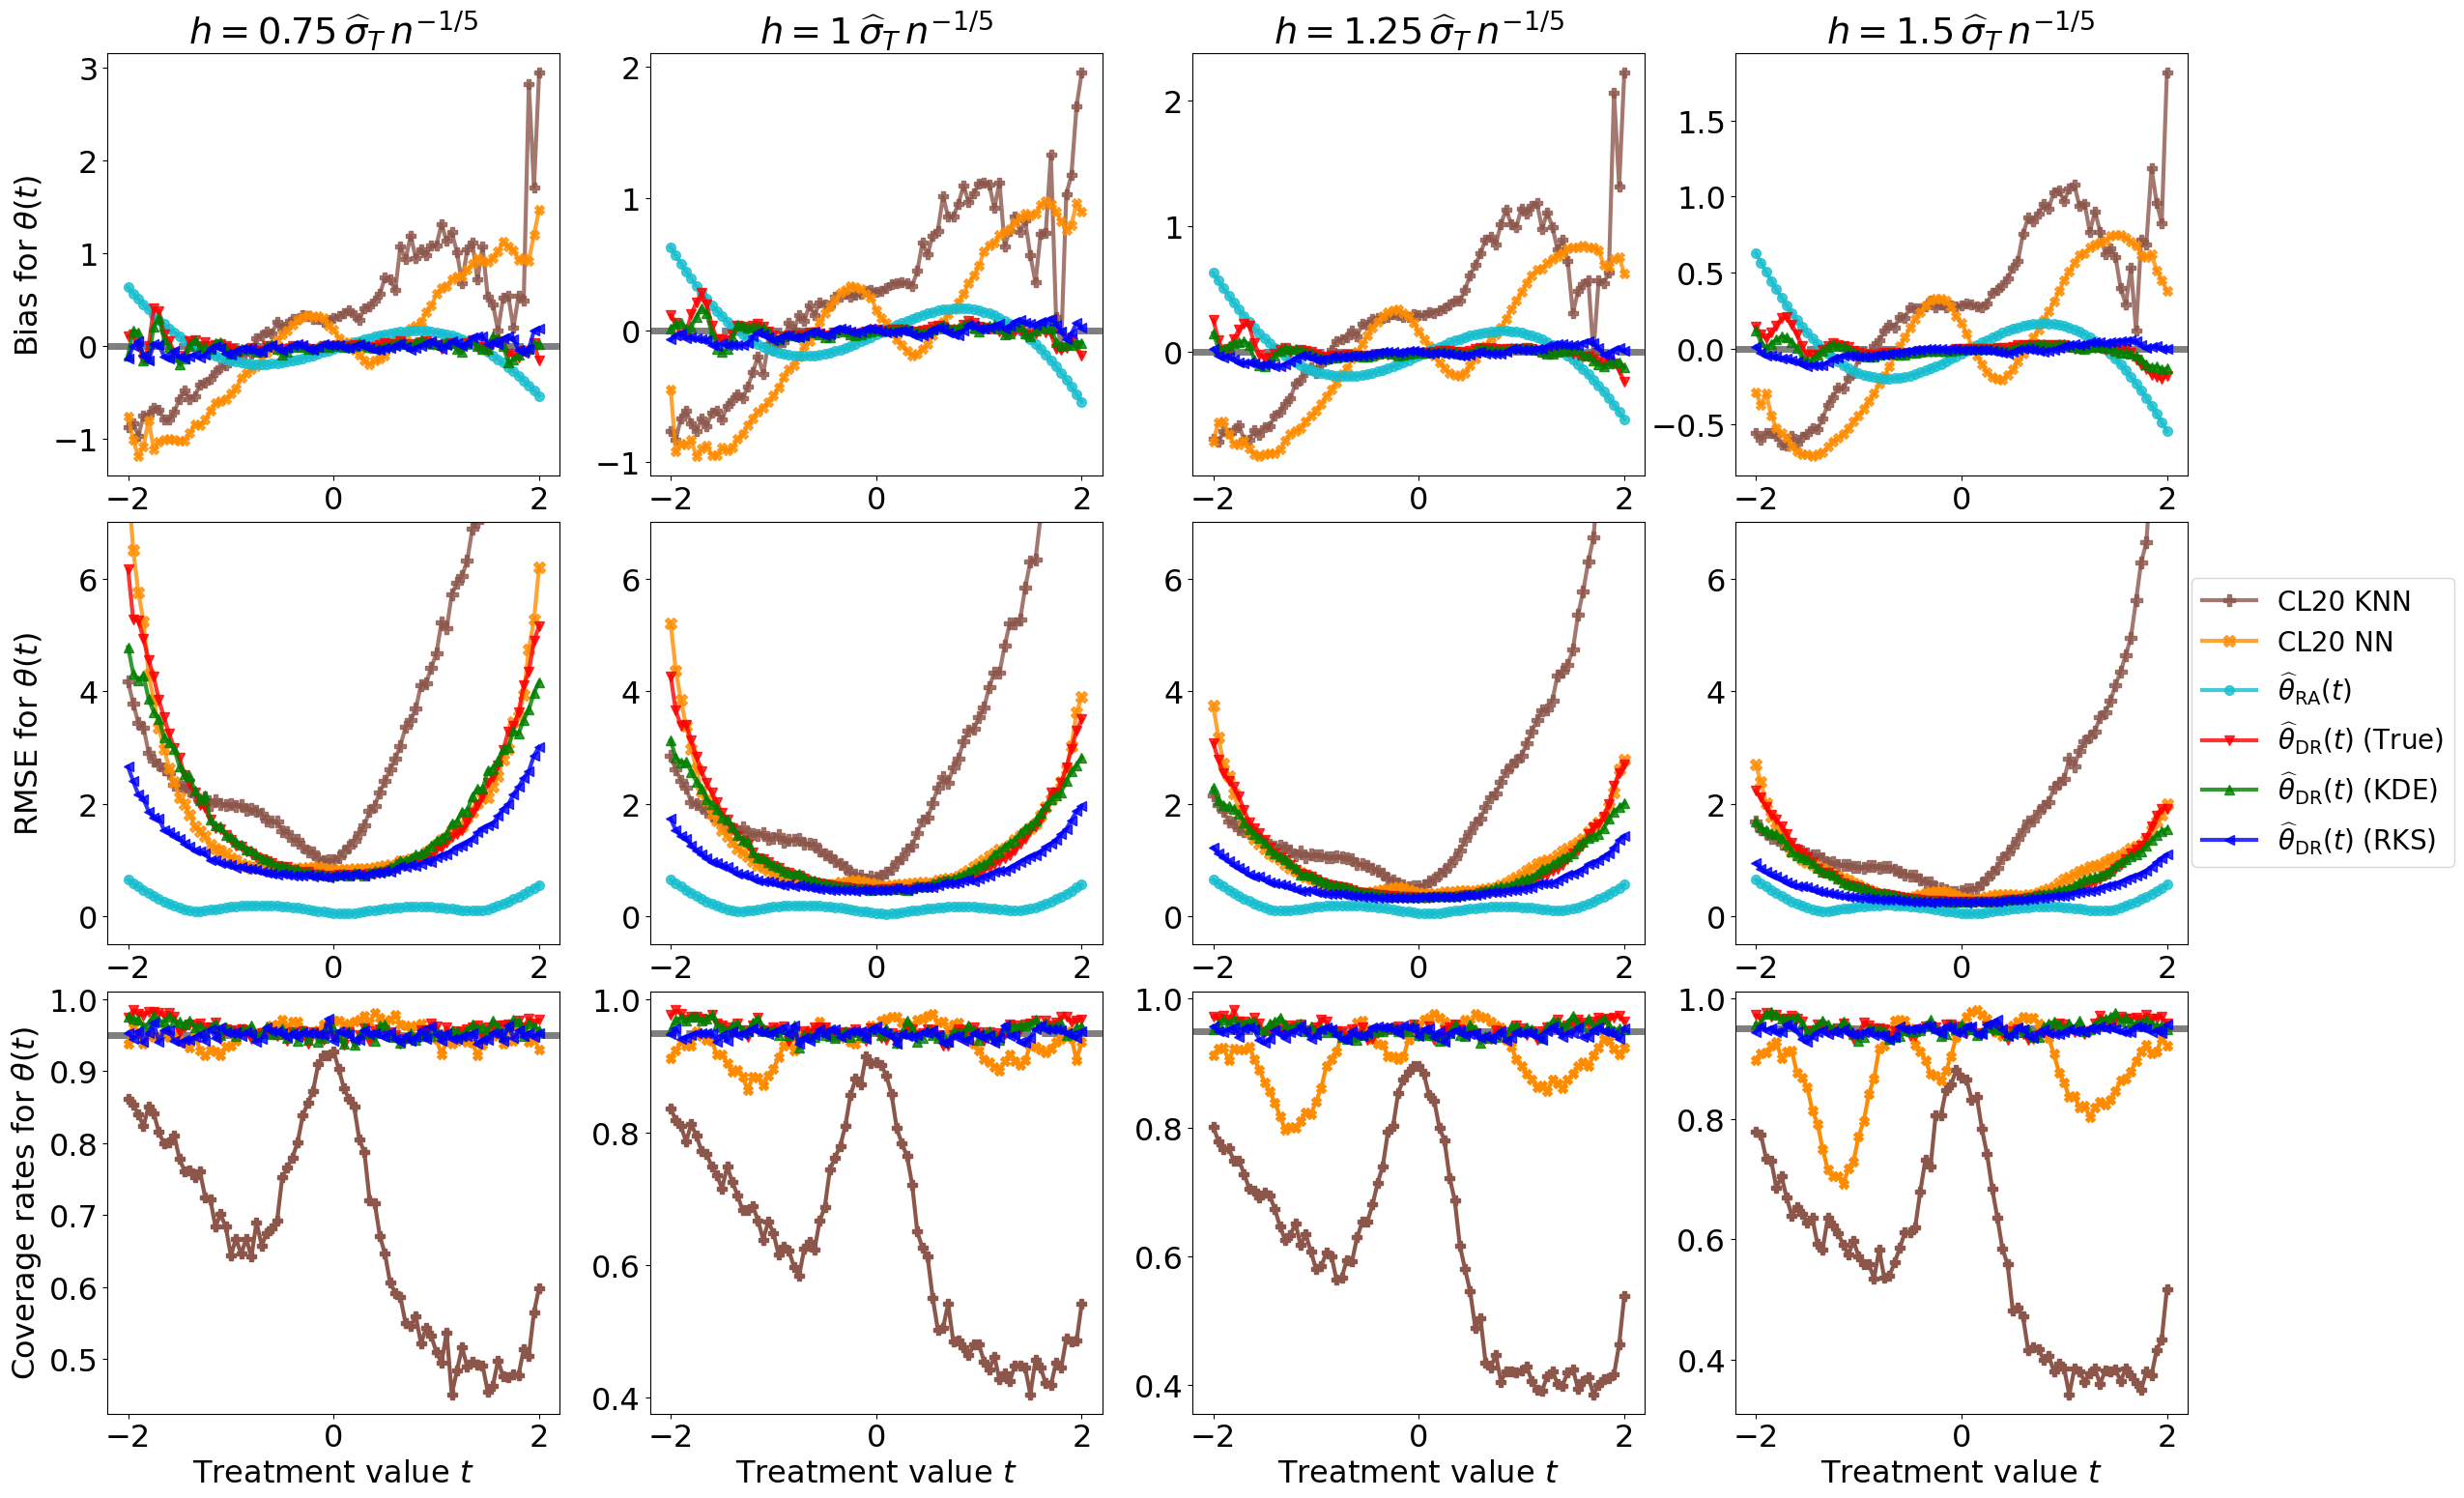

In [8]:
reg = 'NN'
fac_lst = [0.75, 1, 1.25, 1.5]
cond_type = ['true', 'kde', 'reg']
t_qry = np.linspace(-2, 2, 81)
theta_true = 1.2 + 2*t_qry
n = 4000

model_lst = ['knn', 'nn']

j = 0
plt.rcParams.update({'font.size': 23})
fig, ax = plt.subplots(3, 4, figsize=(26, 16))
for fac in fac_lst:
    for cond in cond_type:
        with open('./Syn_Results/Simulation2_theta_est_'+str(reg)+'_h'+str(fac)+'_condmod_'+str(cond)+'_n_'+str(n)+'_selfnorm.dat', "rb") as file:
            theta_ra5_lst, theta_ra1_lst, theta_ipw5_lst, theta_ipw1_lst,\
            theta_dr5_lst, sd_dr5_lst, theta_dr1_lst, sd_dr1_lst = pickle.load(file)
        
        # Bias
        theta_ra1_bias = Bias(np.array(theta_ra1_lst), theta_true)
        theta_ipw1_bias = Bias(np.array(theta_ipw1_lst), theta_true)
        theta_dr1_bias = Bias(np.array(theta_dr1_lst), theta_true)
        
        # RMSE
        theta_ra1_rmse = RMSE(np.array(theta_ra1_lst), theta_true)
        theta_ipw1_rmse = RMSE(np.array(theta_ipw1_lst), theta_true)
        theta_dr1_rmse = RMSE(np.array(theta_dr1_lst), theta_true)
        
        # Coverage
        theta_dr1_cov = CovProb(np.array(theta_dr1_lst), np.array(sd_dr1_lst), theta_true, alpha=0.95)
        
        if cond == 'true':
            res_bias = np.column_stack([t_qry, theta_ra1_bias, theta_ipw1_bias, theta_dr1_bias])
            
            res_rmse = np.column_stack([t_qry, theta_ra1_rmse, theta_ipw1_rmse, theta_dr1_rmse])
            res_cov = np.column_stack([t_qry, theta_dr1_cov])
        else:
            res_bias = np.column_stack([res_bias, theta_ipw1_bias, theta_dr1_bias])
            res_rmse = np.column_stack([res_rmse, theta_ipw1_rmse, theta_dr1_rmse])
            res_cov = np.column_stack([res_cov, theta_dr1_cov])
                                           
    
    res_bias2 = pd.DataFrame(res_bias)
    res_bias2.columns = ['Query point', 'RA', 'IPW (true)', 'DR (true)', 
                         'IPW (KDE)', 'DR (KDE)', 'IPW (reg)', 'DR (reg)']
    
    res_rmse2 = pd.DataFrame(res_rmse)
    res_rmse2.columns = ['Query point', 'RA', 'IPW (true)', 'DR (true)', 
                         'IPW (KDE)', 'DR (KDE)', 'IPW (reg)', 'DR (reg)']
    
    res_cov2 = pd.DataFrame(res_cov)
    res_cov2.columns = ['Query point', 'DR (true)', 'DR (KDE)', 'DR (reg)']
    
    for ml in model_lst:
        with open('./Syn_Results/Sim2_Replicate_est_'+str(ml)+'_h'+str(fac)+'_n_'+str(n)+'.dat', "rb") as file:
            m_est1_lst, m_std1_lst, theta_est1_lst, theta_std1_lst,\
            m_est5_lst, m_std5_lst, theta_est5_lst, theta_std5_lst = pickle.load(file)
        
        theta1_bias = Bias(np.array(theta_est1_lst), theta_true)
        theta1_rmse = RMSE(np.array(theta_est1_lst), theta_true)
        
        theta1_cov = CovProb(np.array(theta_est1_lst), np.array(theta_std1_lst), theta_true, alpha=0.95)
        
        if ml == 'knn':
            res_bias_rep = np.column_stack([t_qry, theta1_bias])
            res_rmse_rep = np.column_stack([t_qry, theta1_rmse])
            res_cov_rep = np.column_stack([t_qry, theta1_cov])
        else:
            res_bias_rep = np.column_stack([res_bias_rep, theta1_bias])
            res_rmse_rep = np.column_stack([res_rmse_rep, theta1_rmse])
            res_cov_rep = np.column_stack([res_cov_rep, theta1_cov])
        
    res_bias2_rep = pd.DataFrame(res_bias_rep)
    res_bias2_rep.columns = ['Query point', 'CL20 KNN', 'CL20 NN']
    
    res_rmse2_rep = pd.DataFrame(res_rmse_rep)
    res_rmse2_rep.columns = ['Query point', 'CL20 KNN', 'CL20 NN']
    
    res_cov2_rep = pd.DataFrame(res_cov_rep)
    res_cov2_rep.columns = ['Query point', 'CL20 KNN', 'CL20 NN']
    
    res_bias2 = res_bias2[['Query point', 'RA', 'DR (true)', 'DR (KDE)', 'DR (reg)']]
    res_rmse2 = res_rmse2[['Query point', 'RA', 'DR (true)', 'DR (KDE)', 'DR (reg)']]
    
    # Plotting bias
    ax[0][j].axhline(y=0, color='black', linestyle='dashed', linewidth=5, alpha=0.5)
    col_lst = ['tab:cyan', 'red', 'green', 'blue']
    col_lab = [r'$\widehat{\theta}_{\mathrm{RA}}(t)$', r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (True)', 
               r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (KDE)', r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS)']
    mark_lst = ["o", "v", "^", "<", "P", "X"]
    col_lst2 = ['tab:brown', 'darkorange']
    for i in range(res_bias2_rep.shape[1] - 1):
        ax[0][j].plot(t_qry, res_bias2_rep.iloc[:,i+1], markersize=7, linewidth=3, marker=mark_lst[i+4], 
                      label=res_bias2_rep.columns[i+1], color=col_lst2[i], alpha=0.8)
    for i in range(res_bias2.shape[1] - 1):
        ax[0][j].plot(t_qry, res_bias2.iloc[:,i+1], markersize=7, linewidth=3, marker=mark_lst[i], 
                      label=col_lab[i], color=col_lst[i], alpha=0.8)
    # ax[0][j].set_xlabel(r'Query point $T=t$')
    ax[0][0].set_ylabel(r'Bias for $\theta(t)$')
    ax[0][j].set_title(r'$h=$'+str(fac)+'$\,\widehat{\sigma}_T \,n^{-1/5}$')
    # ax[0][3].legend(bbox_to_anchor=(1, 0.9))
    
    # Plotting RMSE
    for i in range(res_rmse2_rep.shape[1] - 1):
        ax[1][j].plot(t_qry, res_rmse2_rep.iloc[:,i+1], linewidth=3, markersize=8, marker=mark_lst[i+4], 
                      label=res_rmse2_rep.columns[i+1], color=col_lst2[i], alpha=0.8)
    for i in range(res_rmse2.shape[1] - 1):
        ax[1][j].plot(t_qry, res_rmse2.iloc[:,i+1], linewidth=3, markersize=7, marker=mark_lst[i], 
                      label=col_lab[i], color=col_lst[i], alpha=0.8)
    # ax[1][j].set_xlabel(r'Query point $T=t$')
    ax[1][j].set_ylim([-0.5, 7])
    ax[1][0].set_ylabel(r'RMSE for $\theta(t)$')
    ax[1][3].legend(bbox_to_anchor=(0.98, 0.9), fontsize=20)
    
    # Plotting Coverage
    ax[2][j].axhline(y=0.95, color='black', linestyle='dashed', linewidth=5, alpha=0.5, label='Nominal level')
    for i in range(res_cov2_rep.shape[1] - 1):
        ax[2][j].plot(t_qry, res_cov2_rep.iloc[:,i+1], linewidth=3, markersize=7, marker=mark_lst[i+4], 
                      label=res_cov2_rep.columns[i+1], color=col_lst2[i])
    for i in range(res_cov2.shape[1] - 1):
        ax[2][j].plot(t_qry, res_cov2.iloc[:,i+1], linewidth=3, markersize=7, marker=mark_lst[i+1], 
                      label=col_lab[i+1], color=col_lst[i+1], alpha=0.8)
    ax[2][j].set_xlabel(r'Treatment value $t$')
    ax[2][0].set_ylabel(r'Coverage rates for $\theta(t)$')
    # ax[2][j].set_ylim([0.56, 1])
    # ax[2][3].legend(bbox_to_anchor=(1, 0.9))
    
    j += 1
fig.align_ylabels()
fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.11)
fig.savefig('./Figures/theta_L1_selfnorm.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

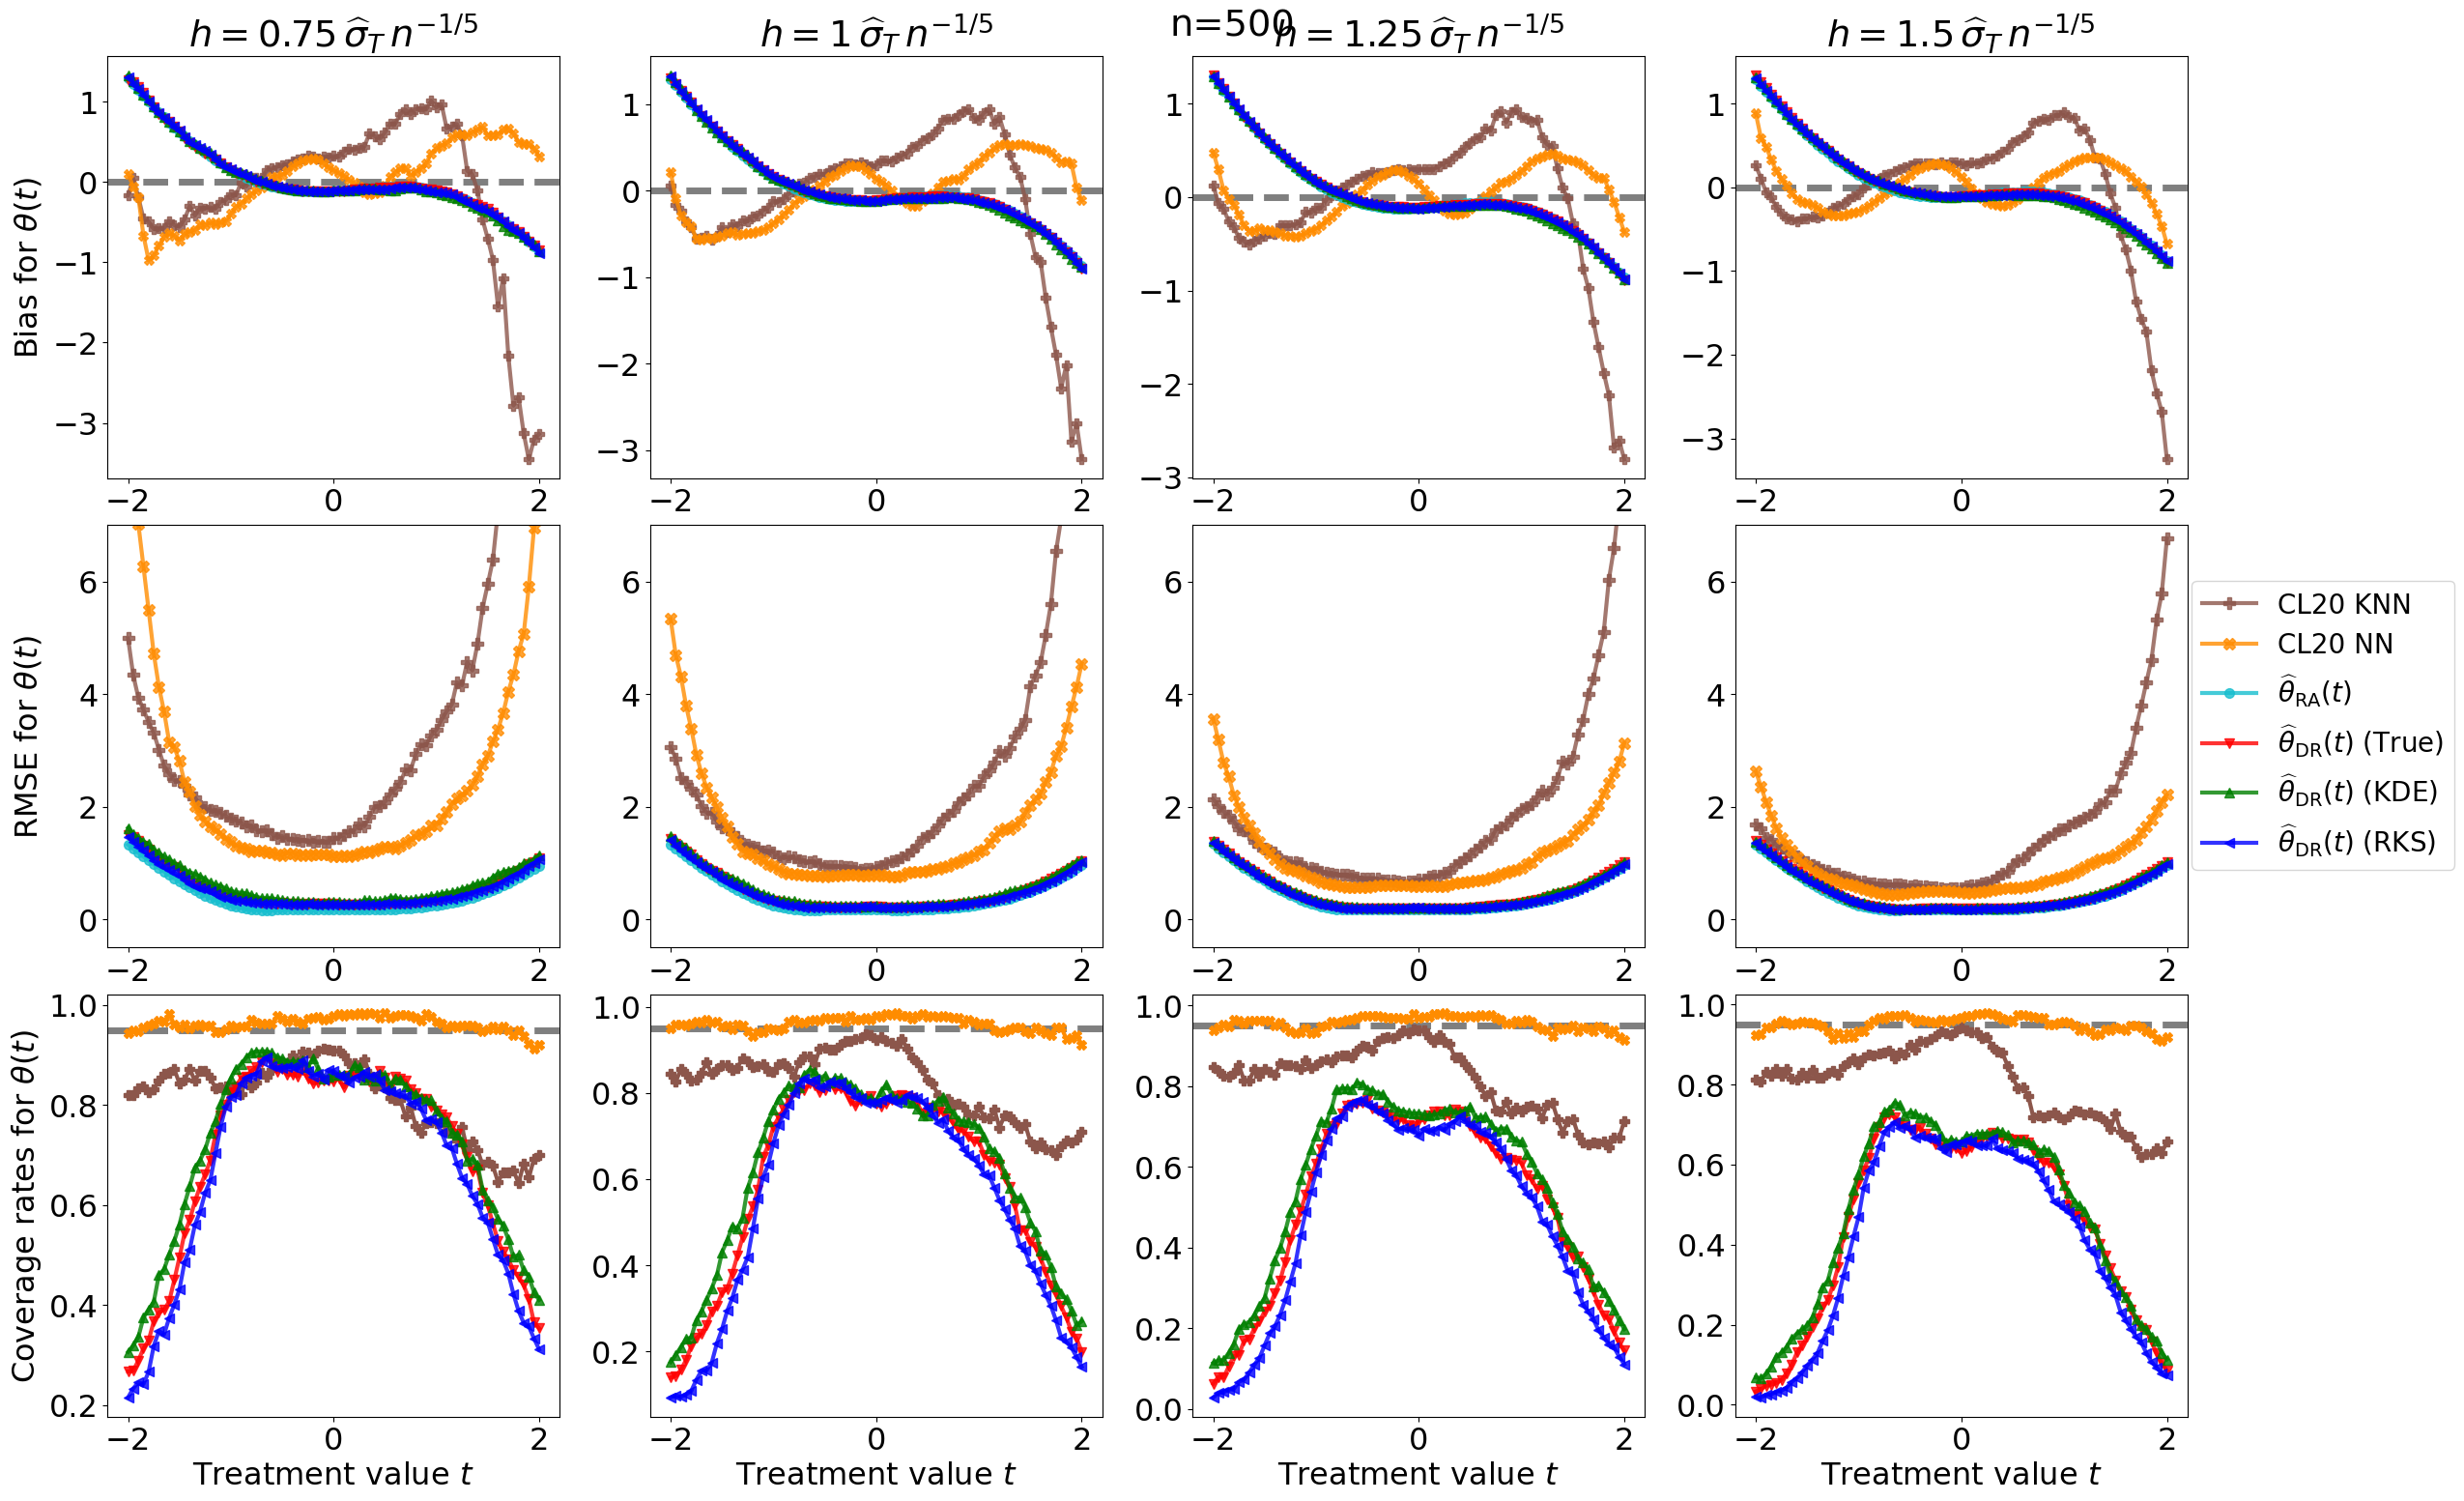

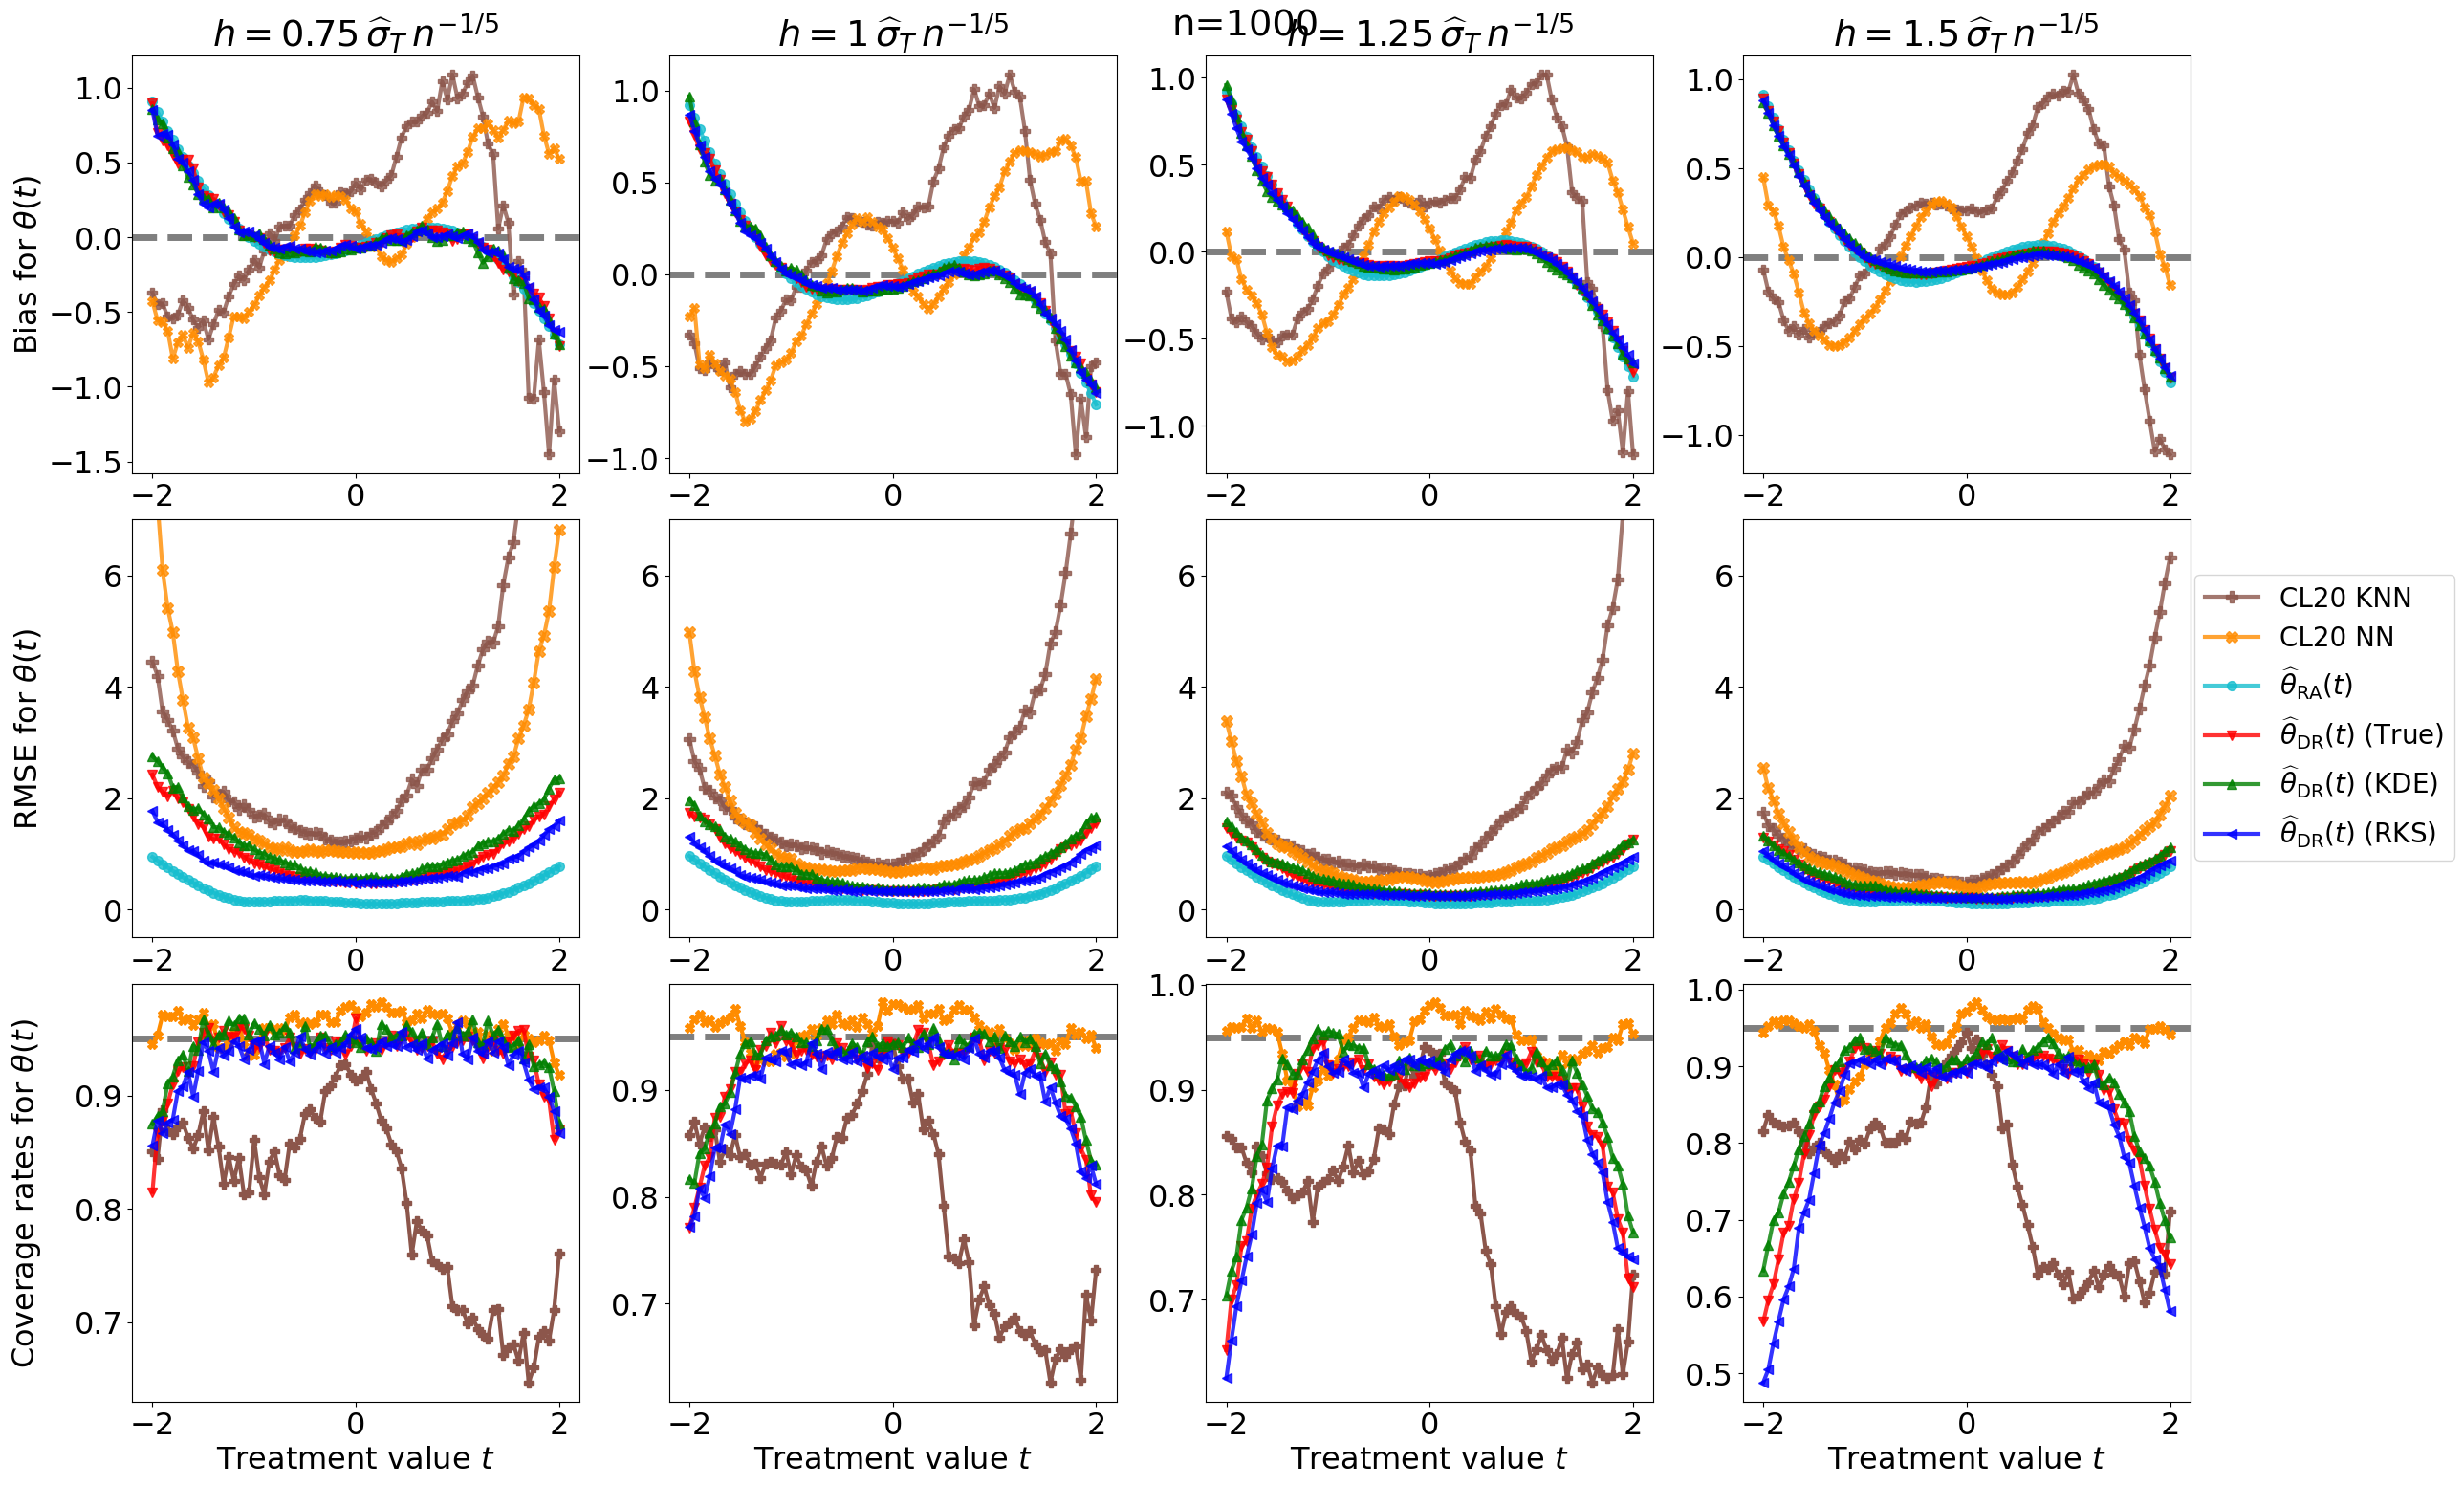

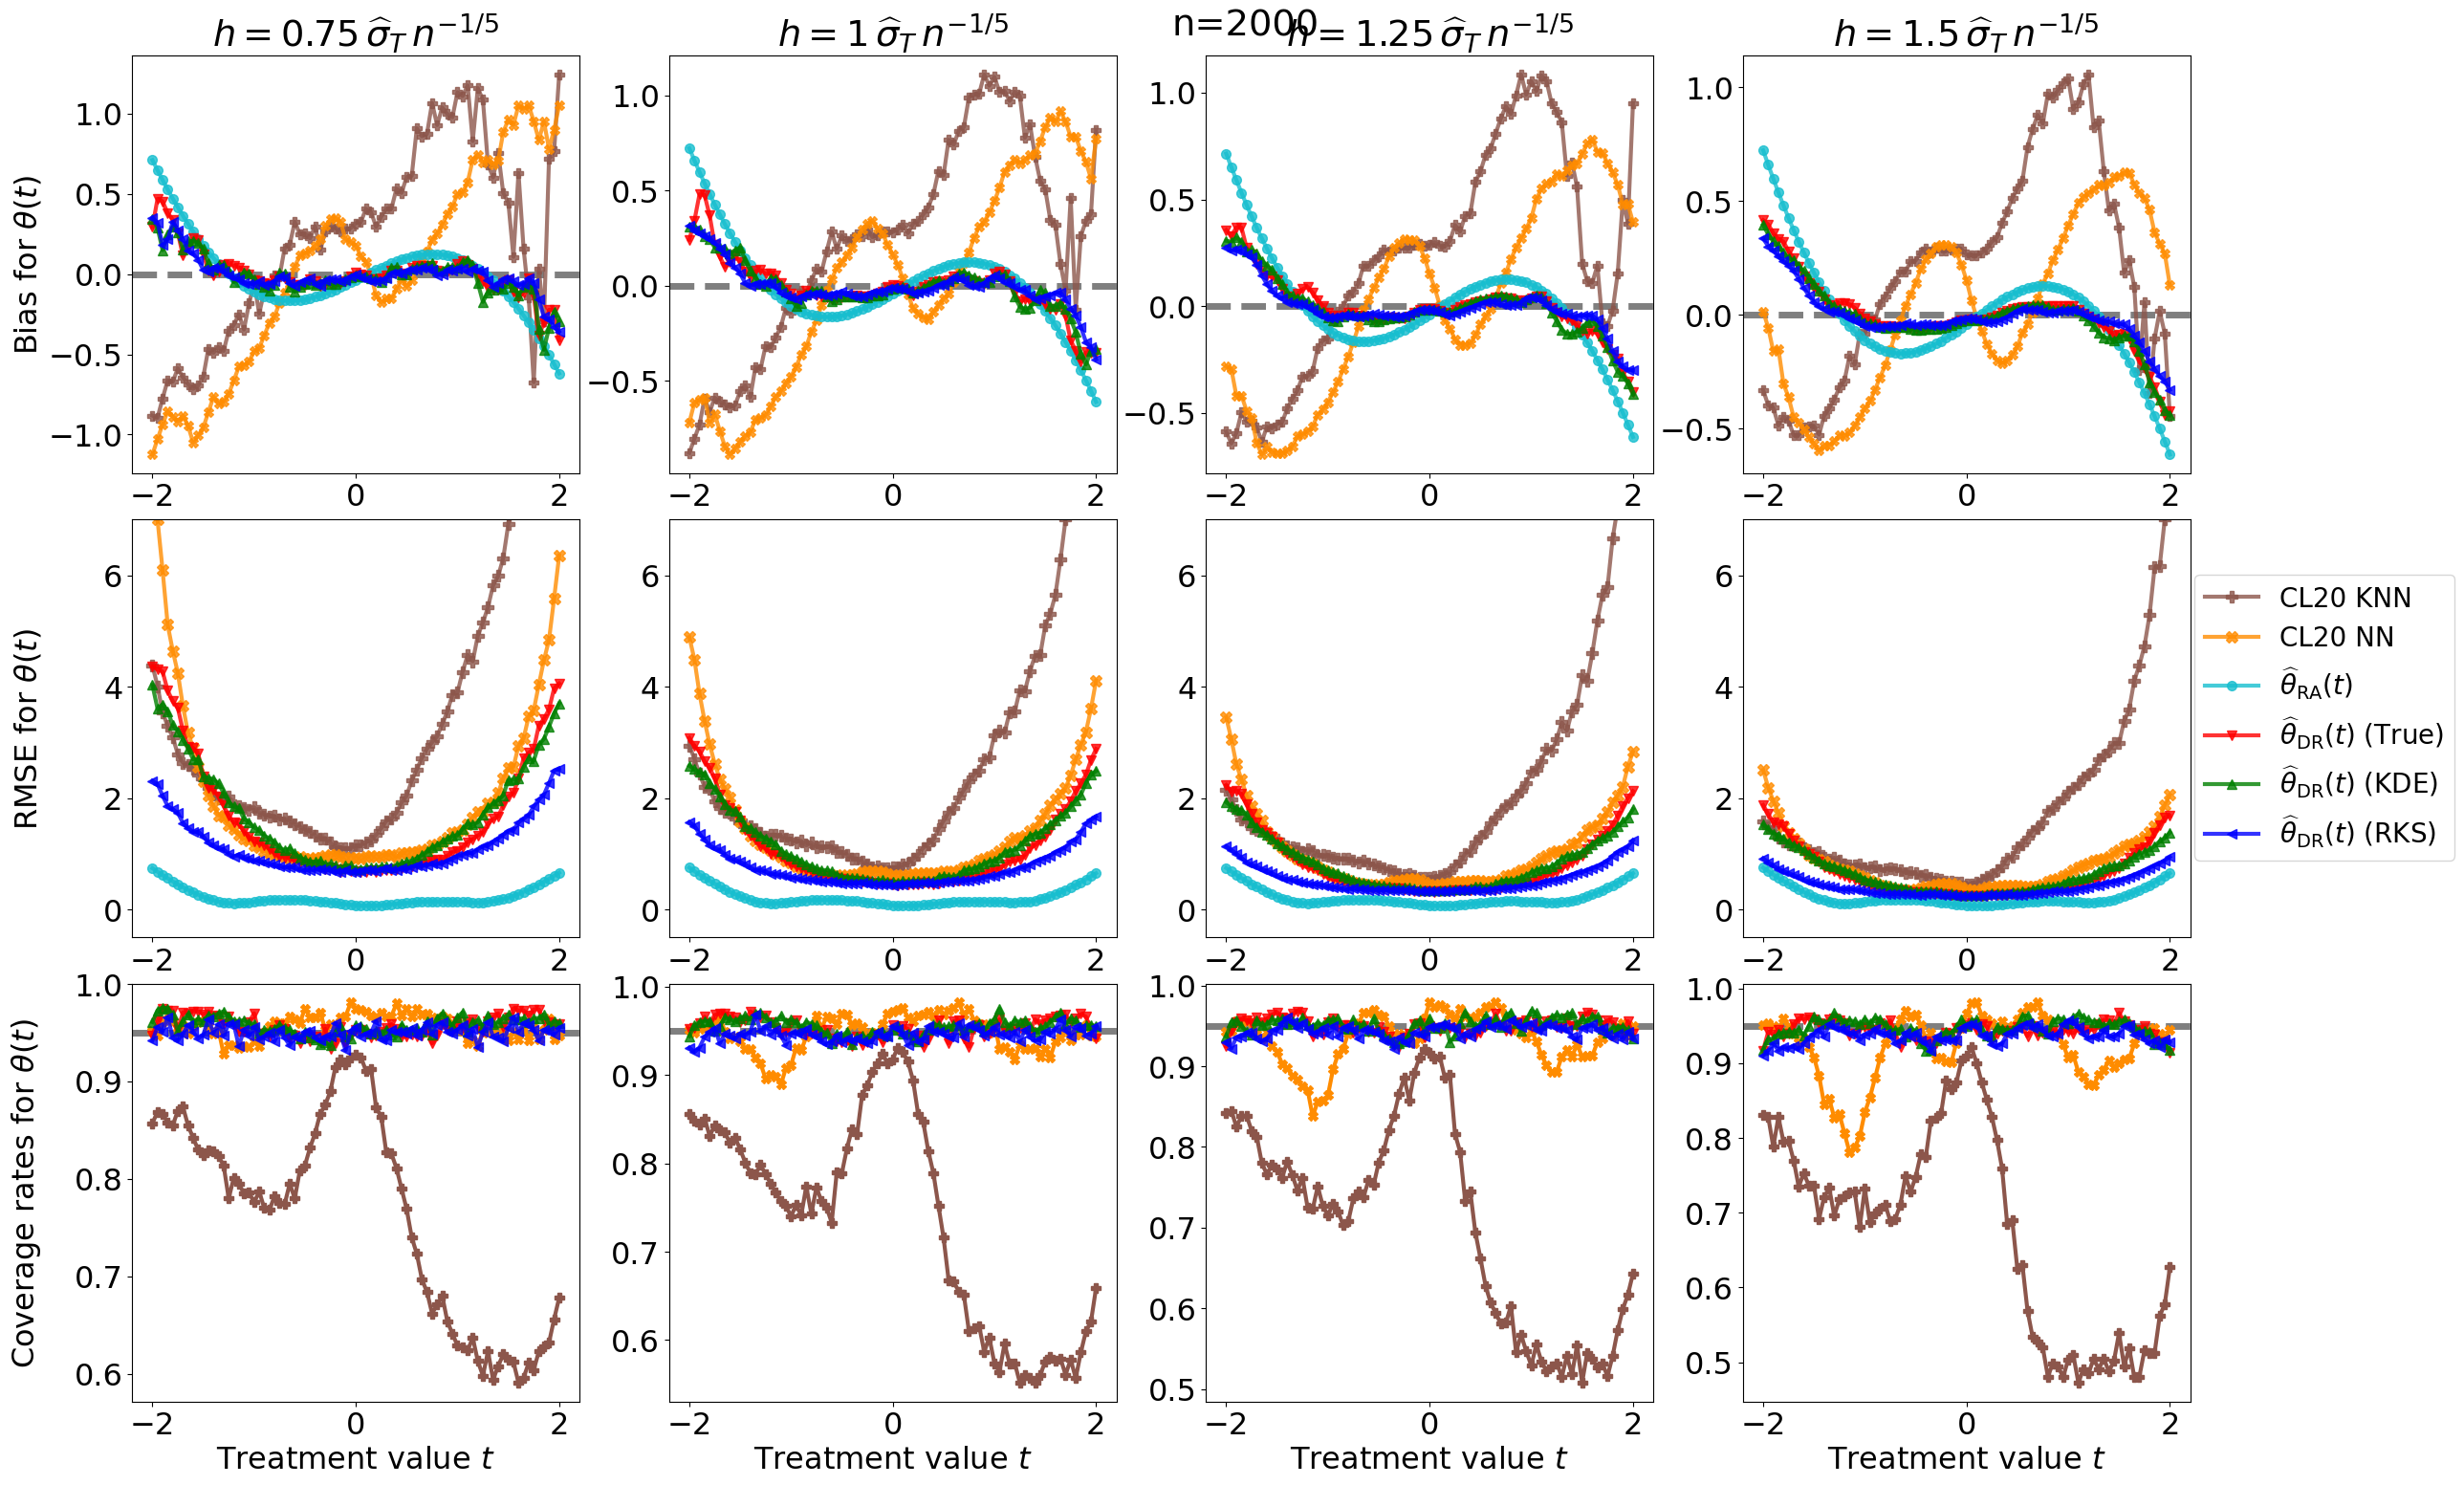

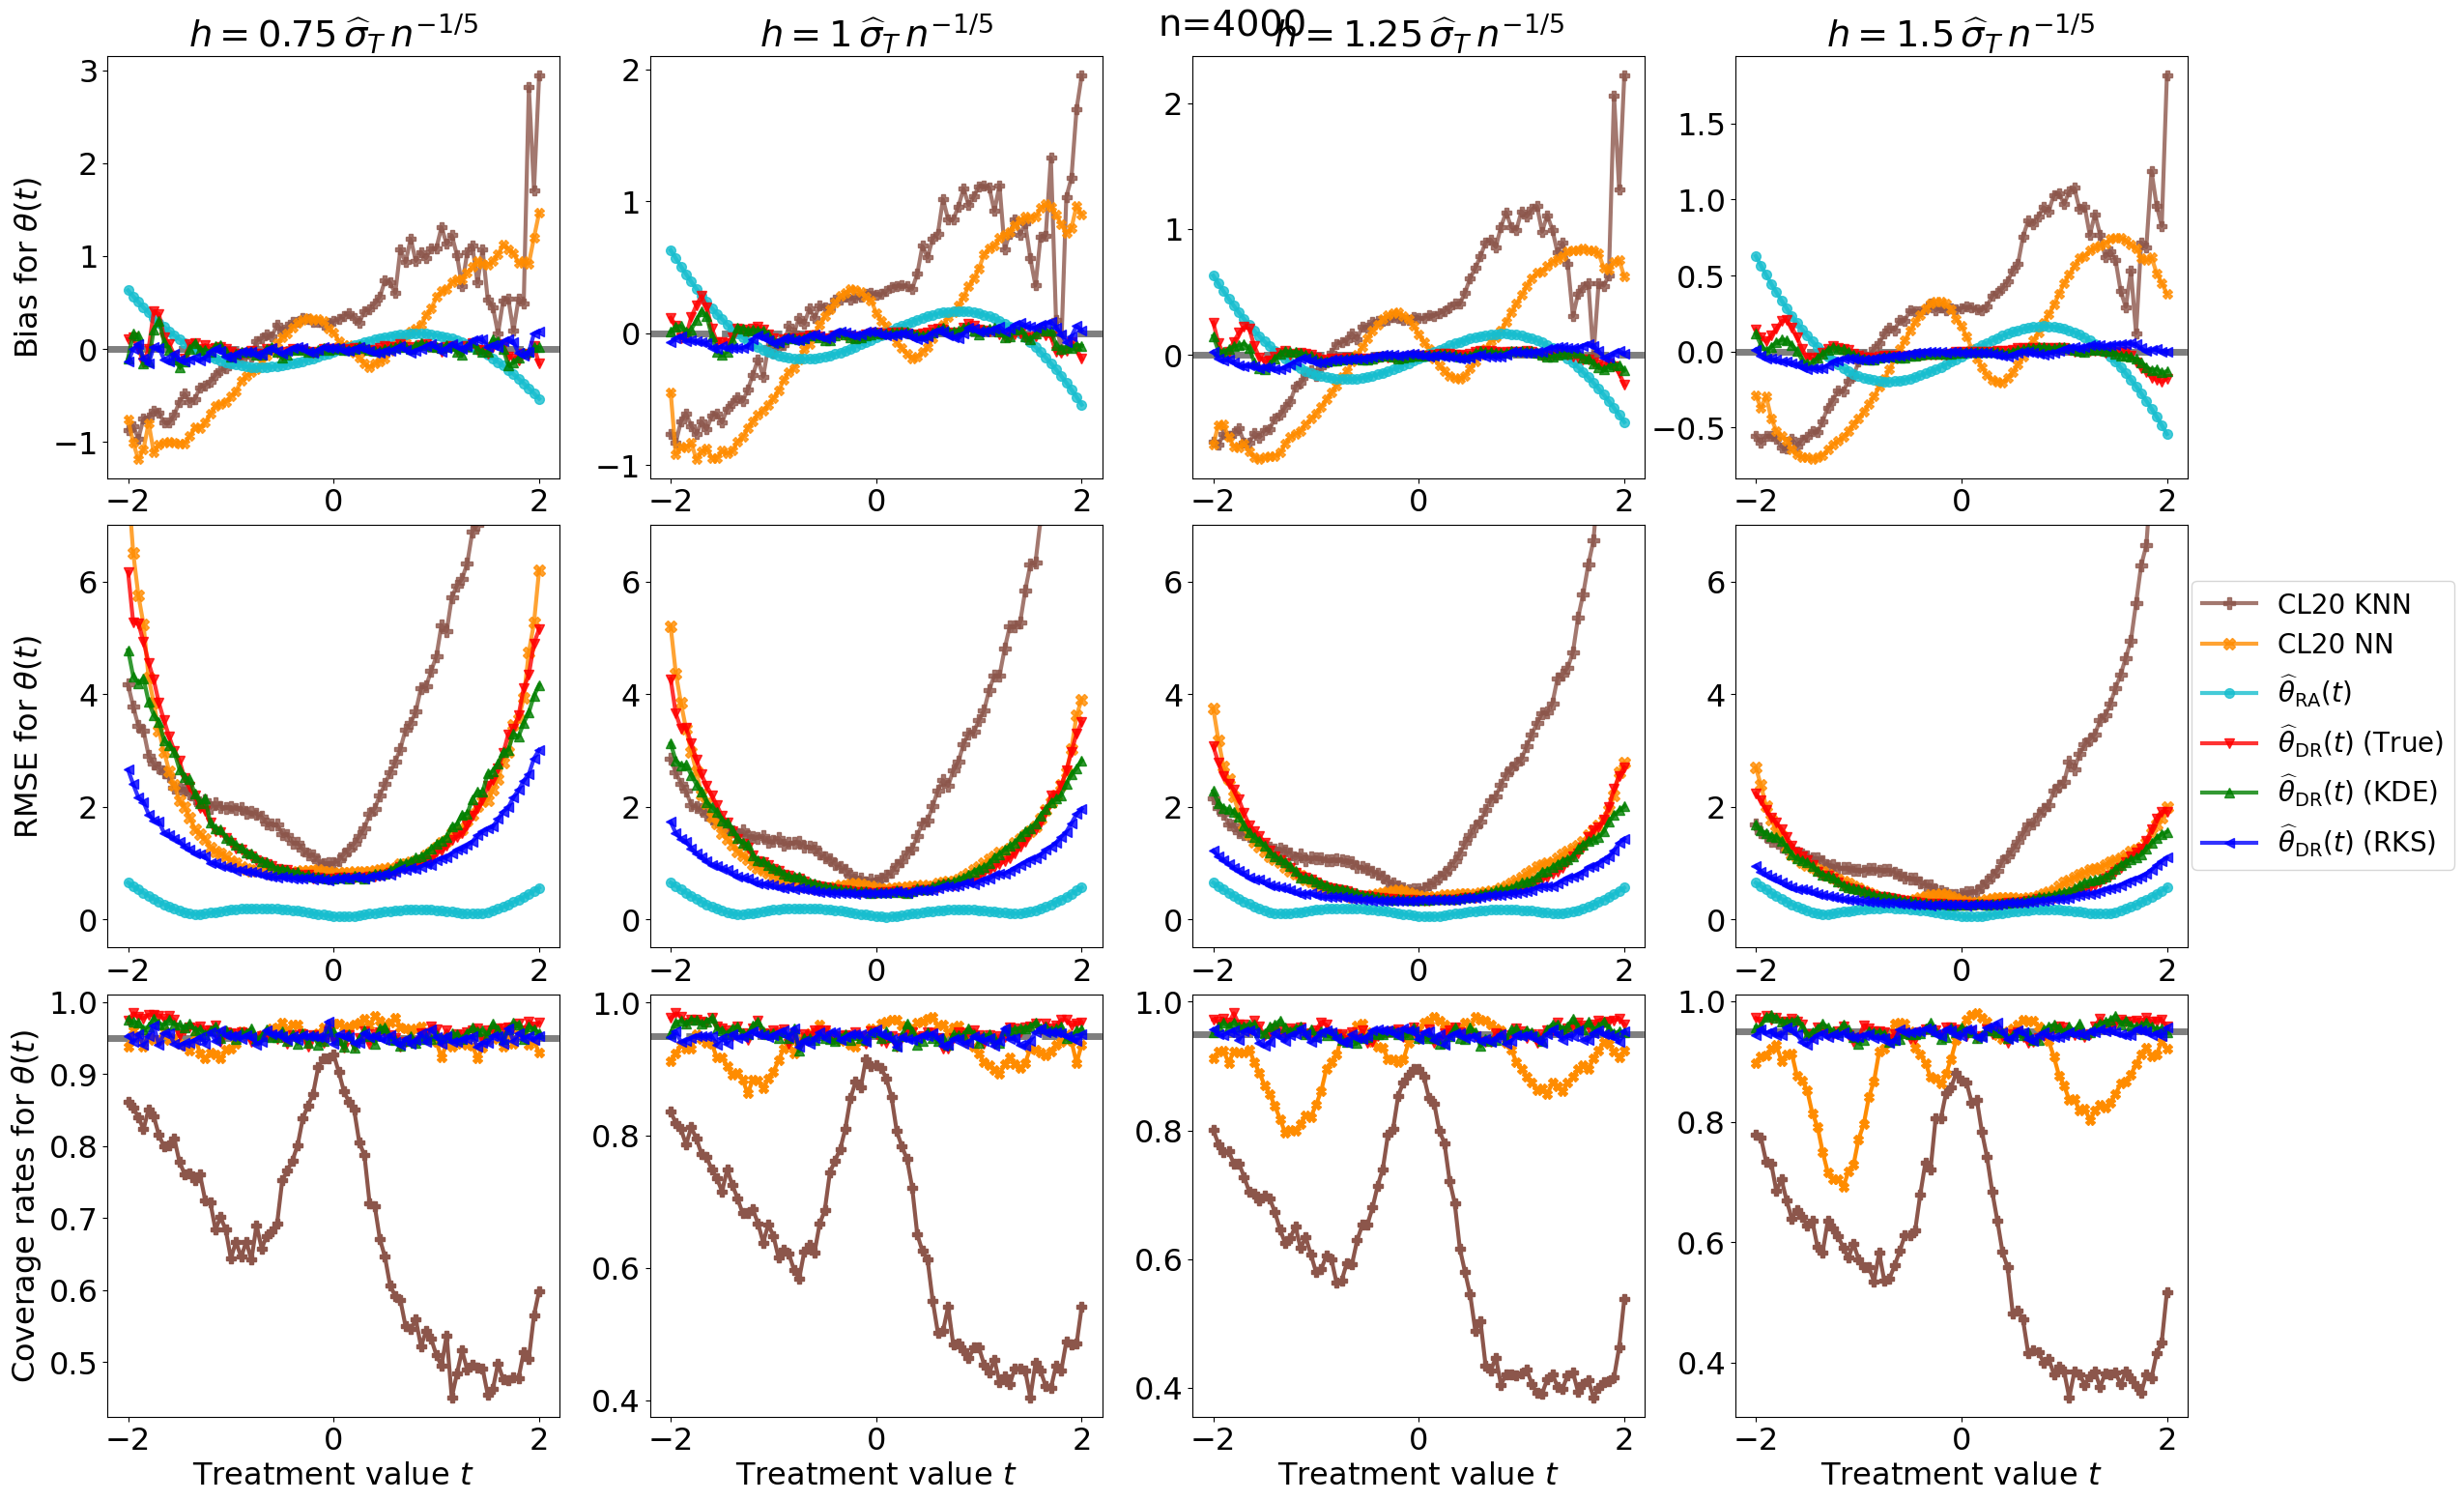

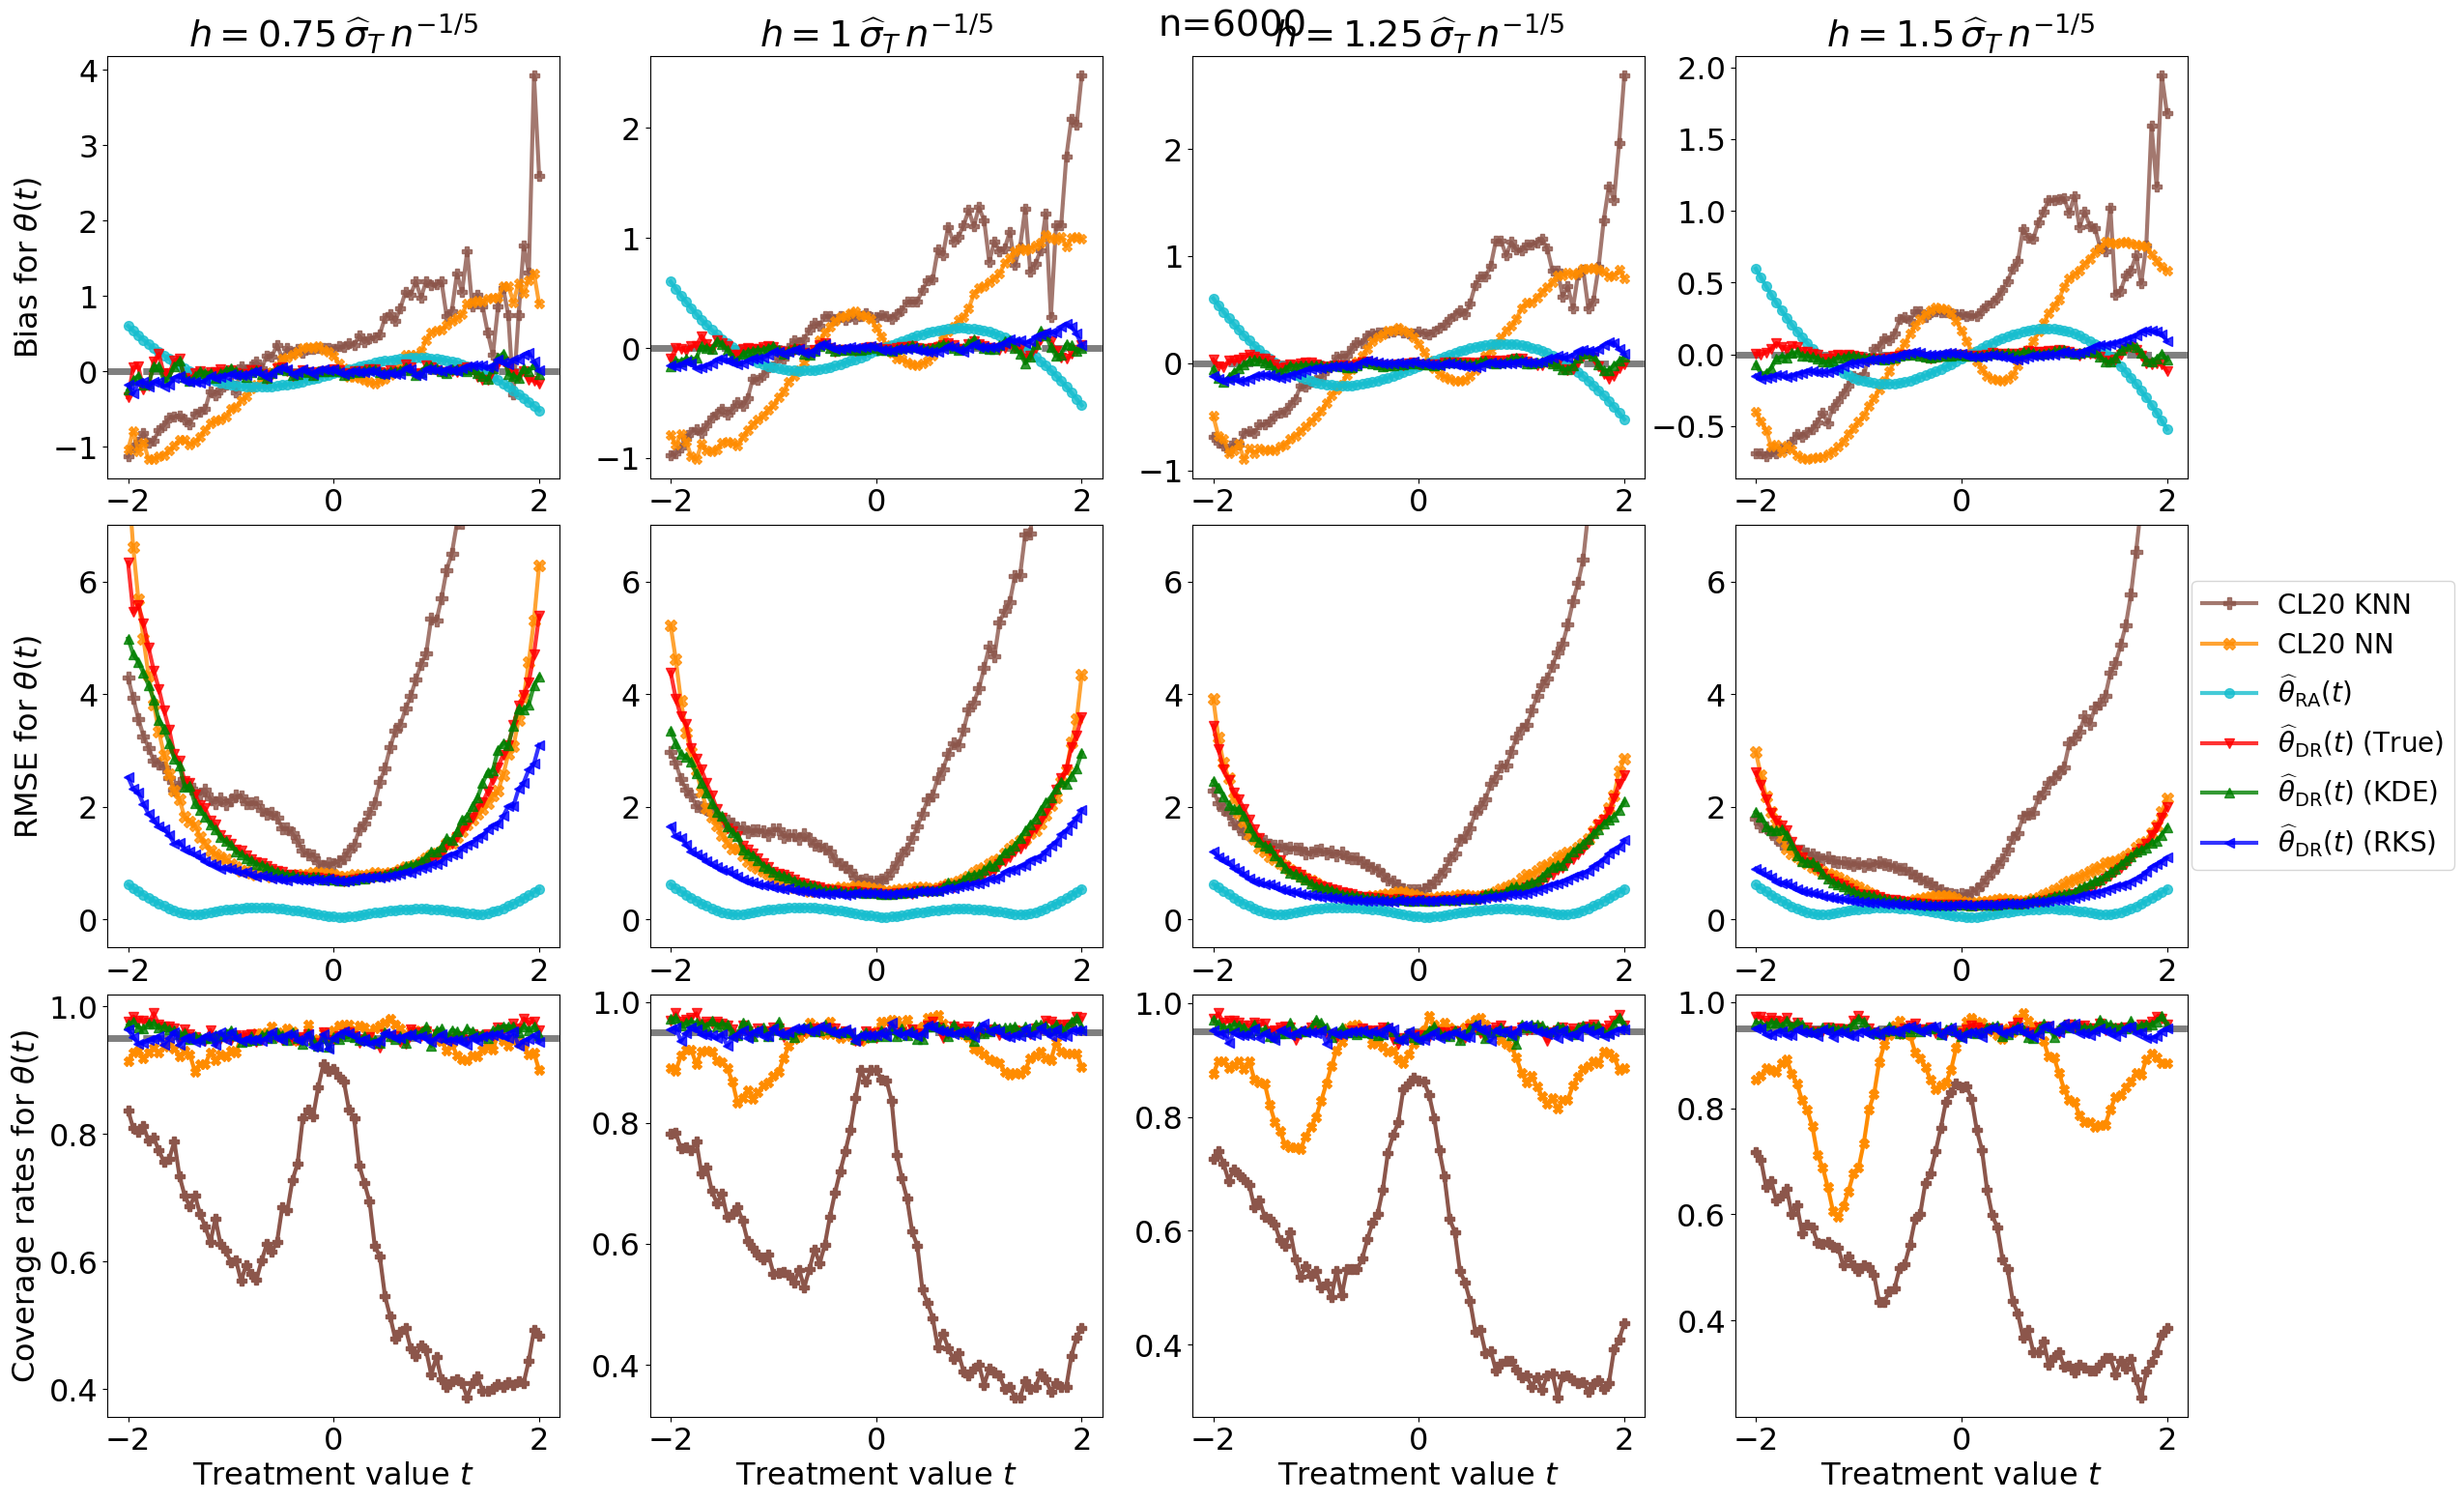

In [5]:
reg = 'NN'
fac_lst = [0.75, 1, 1.25, 1.5]
cond_type = ['true', 'kde', 'reg']
t_qry = np.linspace(-2, 2, 81)
theta_true = 1.2 + 2*t_qry

model_lst = ['knn', 'nn']

n_lst = [500, 1000, 2000, 4000, 6000]
for n in n_lst:
    j = 0
    plt.rcParams.update({'font.size': 23})
    fig, ax = plt.subplots(3, 4, figsize=(26, 16))
    for fac in fac_lst:
        for cond in cond_type:
            with open('./Syn_Results/Simulation2_theta_est_'+str(reg)+'_h'+str(fac)+'_condmod_'+str(cond)+'_n_'+str(n)+'_selfnorm.dat', "rb") as file:
                theta_ra5_lst, theta_ra1_lst, theta_ipw5_lst, theta_ipw1_lst,\
                theta_dr5_lst, sd_dr5_lst, theta_dr1_lst, sd_dr1_lst = pickle.load(file)
            
            # Bias
            theta_ra1_bias = Bias(np.array(theta_ra1_lst), theta_true)
            theta_ipw1_bias = Bias(np.array(theta_ipw1_lst), theta_true)
            theta_dr1_bias = Bias(np.array(theta_dr1_lst), theta_true)
            
            # RMSE
            theta_ra1_rmse = RMSE(np.array(theta_ra1_lst), theta_true)
            theta_ipw1_rmse = RMSE(np.array(theta_ipw1_lst), theta_true)
            theta_dr1_rmse = RMSE(np.array(theta_dr1_lst), theta_true)
            
            # Coverage
            theta_dr1_cov = CovProb(np.array(theta_dr1_lst), np.array(sd_dr1_lst), theta_true, alpha=0.95)
            
            if cond == 'true':
                res_bias = np.column_stack([t_qry, theta_ra1_bias, theta_ipw1_bias, theta_dr1_bias])
                
                res_rmse = np.column_stack([t_qry, theta_ra1_rmse, theta_ipw1_rmse, theta_dr1_rmse])
                res_cov = np.column_stack([t_qry, theta_dr1_cov])
            else:
                res_bias = np.column_stack([res_bias, theta_ipw1_bias, theta_dr1_bias])
                res_rmse = np.column_stack([res_rmse, theta_ipw1_rmse, theta_dr1_rmse])
                res_cov = np.column_stack([res_cov, theta_dr1_cov])
                                               
        
        res_bias2 = pd.DataFrame(res_bias)
        res_bias2.columns = ['Query point', 'RA', 'IPW (true)', 'DR (true)', 
                             'IPW (KDE)', 'DR (KDE)', 'IPW (reg)', 'DR (reg)']
        
        res_rmse2 = pd.DataFrame(res_rmse)
        res_rmse2.columns = ['Query point', 'RA', 'IPW (true)', 'DR (true)', 
                             'IPW (KDE)', 'DR (KDE)', 'IPW (reg)', 'DR (reg)']
        
        res_cov2 = pd.DataFrame(res_cov)
        res_cov2.columns = ['Query point', 'DR (true)', 'DR (KDE)', 'DR (reg)']
        
        for ml in model_lst:
            with open('./Syn_Results/Sim2_Replicate_est_'+str(ml)+'_h'+str(fac)+'_n_'+str(n)+'.dat', "rb") as file:
                m_est1_lst, m_std1_lst, theta_est1_lst, theta_std1_lst,\
                m_est5_lst, m_std5_lst, theta_est5_lst, theta_std5_lst = pickle.load(file)
            
            theta1_bias = Bias(np.array(theta_est1_lst), theta_true)
            theta1_rmse = RMSE(np.array(theta_est1_lst), theta_true)
            
            theta1_cov = CovProb(np.array(theta_est1_lst), np.array(theta_std1_lst), theta_true, alpha=0.95)
            
            if ml == 'knn':
                res_bias_rep = np.column_stack([t_qry, theta1_bias])
                res_rmse_rep = np.column_stack([t_qry, theta1_rmse])
                res_cov_rep = np.column_stack([t_qry, theta1_cov])
            else:
                res_bias_rep = np.column_stack([res_bias_rep, theta1_bias])
                res_rmse_rep = np.column_stack([res_rmse_rep, theta1_rmse])
                res_cov_rep = np.column_stack([res_cov_rep, theta1_cov])
            
        res_bias2_rep = pd.DataFrame(res_bias_rep)
        res_bias2_rep.columns = ['Query point', 'CL20 KNN', 'CL20 NN']
        
        res_rmse2_rep = pd.DataFrame(res_rmse_rep)
        res_rmse2_rep.columns = ['Query point', 'CL20 KNN', 'CL20 NN']
        
        res_cov2_rep = pd.DataFrame(res_cov_rep)
        res_cov2_rep.columns = ['Query point', 'CL20 KNN', 'CL20 NN']
        
        res_bias2 = res_bias2[['Query point', 'RA', 'DR (true)', 'DR (KDE)', 'DR (reg)']]
        res_rmse2 = res_rmse2[['Query point', 'RA', 'DR (true)', 'DR (KDE)', 'DR (reg)']]
        
        # Plotting bias
        ax[0][j].axhline(y=0, color='black', linestyle='dashed', linewidth=5, alpha=0.5)
        col_lst = ['tab:cyan', 'red', 'green', 'blue']
        col_lab = [r'$\widehat{\theta}_{\mathrm{RA}}(t)$', r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (True)', 
                   r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (KDE)', r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS)']
        mark_lst = ["o", "v", "^", "<", "P", "X"]
        col_lst2 = ['tab:brown', 'darkorange']
        for i in range(res_bias2_rep.shape[1] - 1):
            ax[0][j].plot(t_qry, res_bias2_rep.iloc[:,i+1], markersize=7, linewidth=3, marker=mark_lst[i+4], 
                          label=res_bias2_rep.columns[i+1], color=col_lst2[i], alpha=0.8)
        for i in range(res_bias2.shape[1] - 1):
            ax[0][j].plot(t_qry, res_bias2.iloc[:,i+1], markersize=7, linewidth=3, marker=mark_lst[i], 
                          label=col_lab[i], color=col_lst[i], alpha=0.8)
        # ax[0][j].set_xlabel(r'Query point $T=t$')
        ax[0][0].set_ylabel(r'Bias for $\theta(t)$')
        ax[0][j].set_title(r'$h=$'+str(fac)+'$\,\widehat{\sigma}_T \,n^{-1/5}$')
        # ax[0][3].legend(bbox_to_anchor=(1, 0.9))
        
        # Plotting RMSE
        for i in range(res_rmse2_rep.shape[1] - 1):
            ax[1][j].plot(t_qry, res_rmse2_rep.iloc[:,i+1], linewidth=3, markersize=8, marker=mark_lst[i+4], 
                          label=res_rmse2_rep.columns[i+1], color=col_lst2[i], alpha=0.8)
        for i in range(res_rmse2.shape[1] - 1):
            ax[1][j].plot(t_qry, res_rmse2.iloc[:,i+1], linewidth=3, markersize=7, marker=mark_lst[i], 
                          label=col_lab[i], color=col_lst[i], alpha=0.8)
        # ax[1][j].set_xlabel(r'Query point $T=t$')
        ax[1][j].set_ylim([-0.5, 7])
        ax[1][0].set_ylabel(r'RMSE for $\theta(t)$')
        ax[1][3].legend(bbox_to_anchor=(0.98, 0.9), fontsize=20)
        
        # Plotting Coverage
        ax[2][j].axhline(y=0.95, color='black', linestyle='dashed', linewidth=5, alpha=0.5, label='Nominal level')
        for i in range(res_cov2_rep.shape[1] - 1):
            ax[2][j].plot(t_qry, res_cov2_rep.iloc[:,i+1], linewidth=3, markersize=7, marker=mark_lst[i+4], 
                          label=res_cov2_rep.columns[i+1], color=col_lst2[i])
        for i in range(res_cov2.shape[1] - 1):
            ax[2][j].plot(t_qry, res_cov2.iloc[:,i+1], linewidth=3, markersize=7, marker=mark_lst[i+1], 
                          label=col_lab[i+1], color=col_lst[i+1], alpha=0.8)
        ax[2][j].set_xlabel(r'Treatment value $t$')
        ax[2][0].set_ylabel(r'Coverage rates for $\theta(t)$')
        # ax[2][j].set_ylim([0.56, 1])
        # ax[2][3].legend(bbox_to_anchor=(1, 0.9))
        
        j += 1
    fig.align_ylabels()
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0.11)
    fig.suptitle('n='+str(n))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


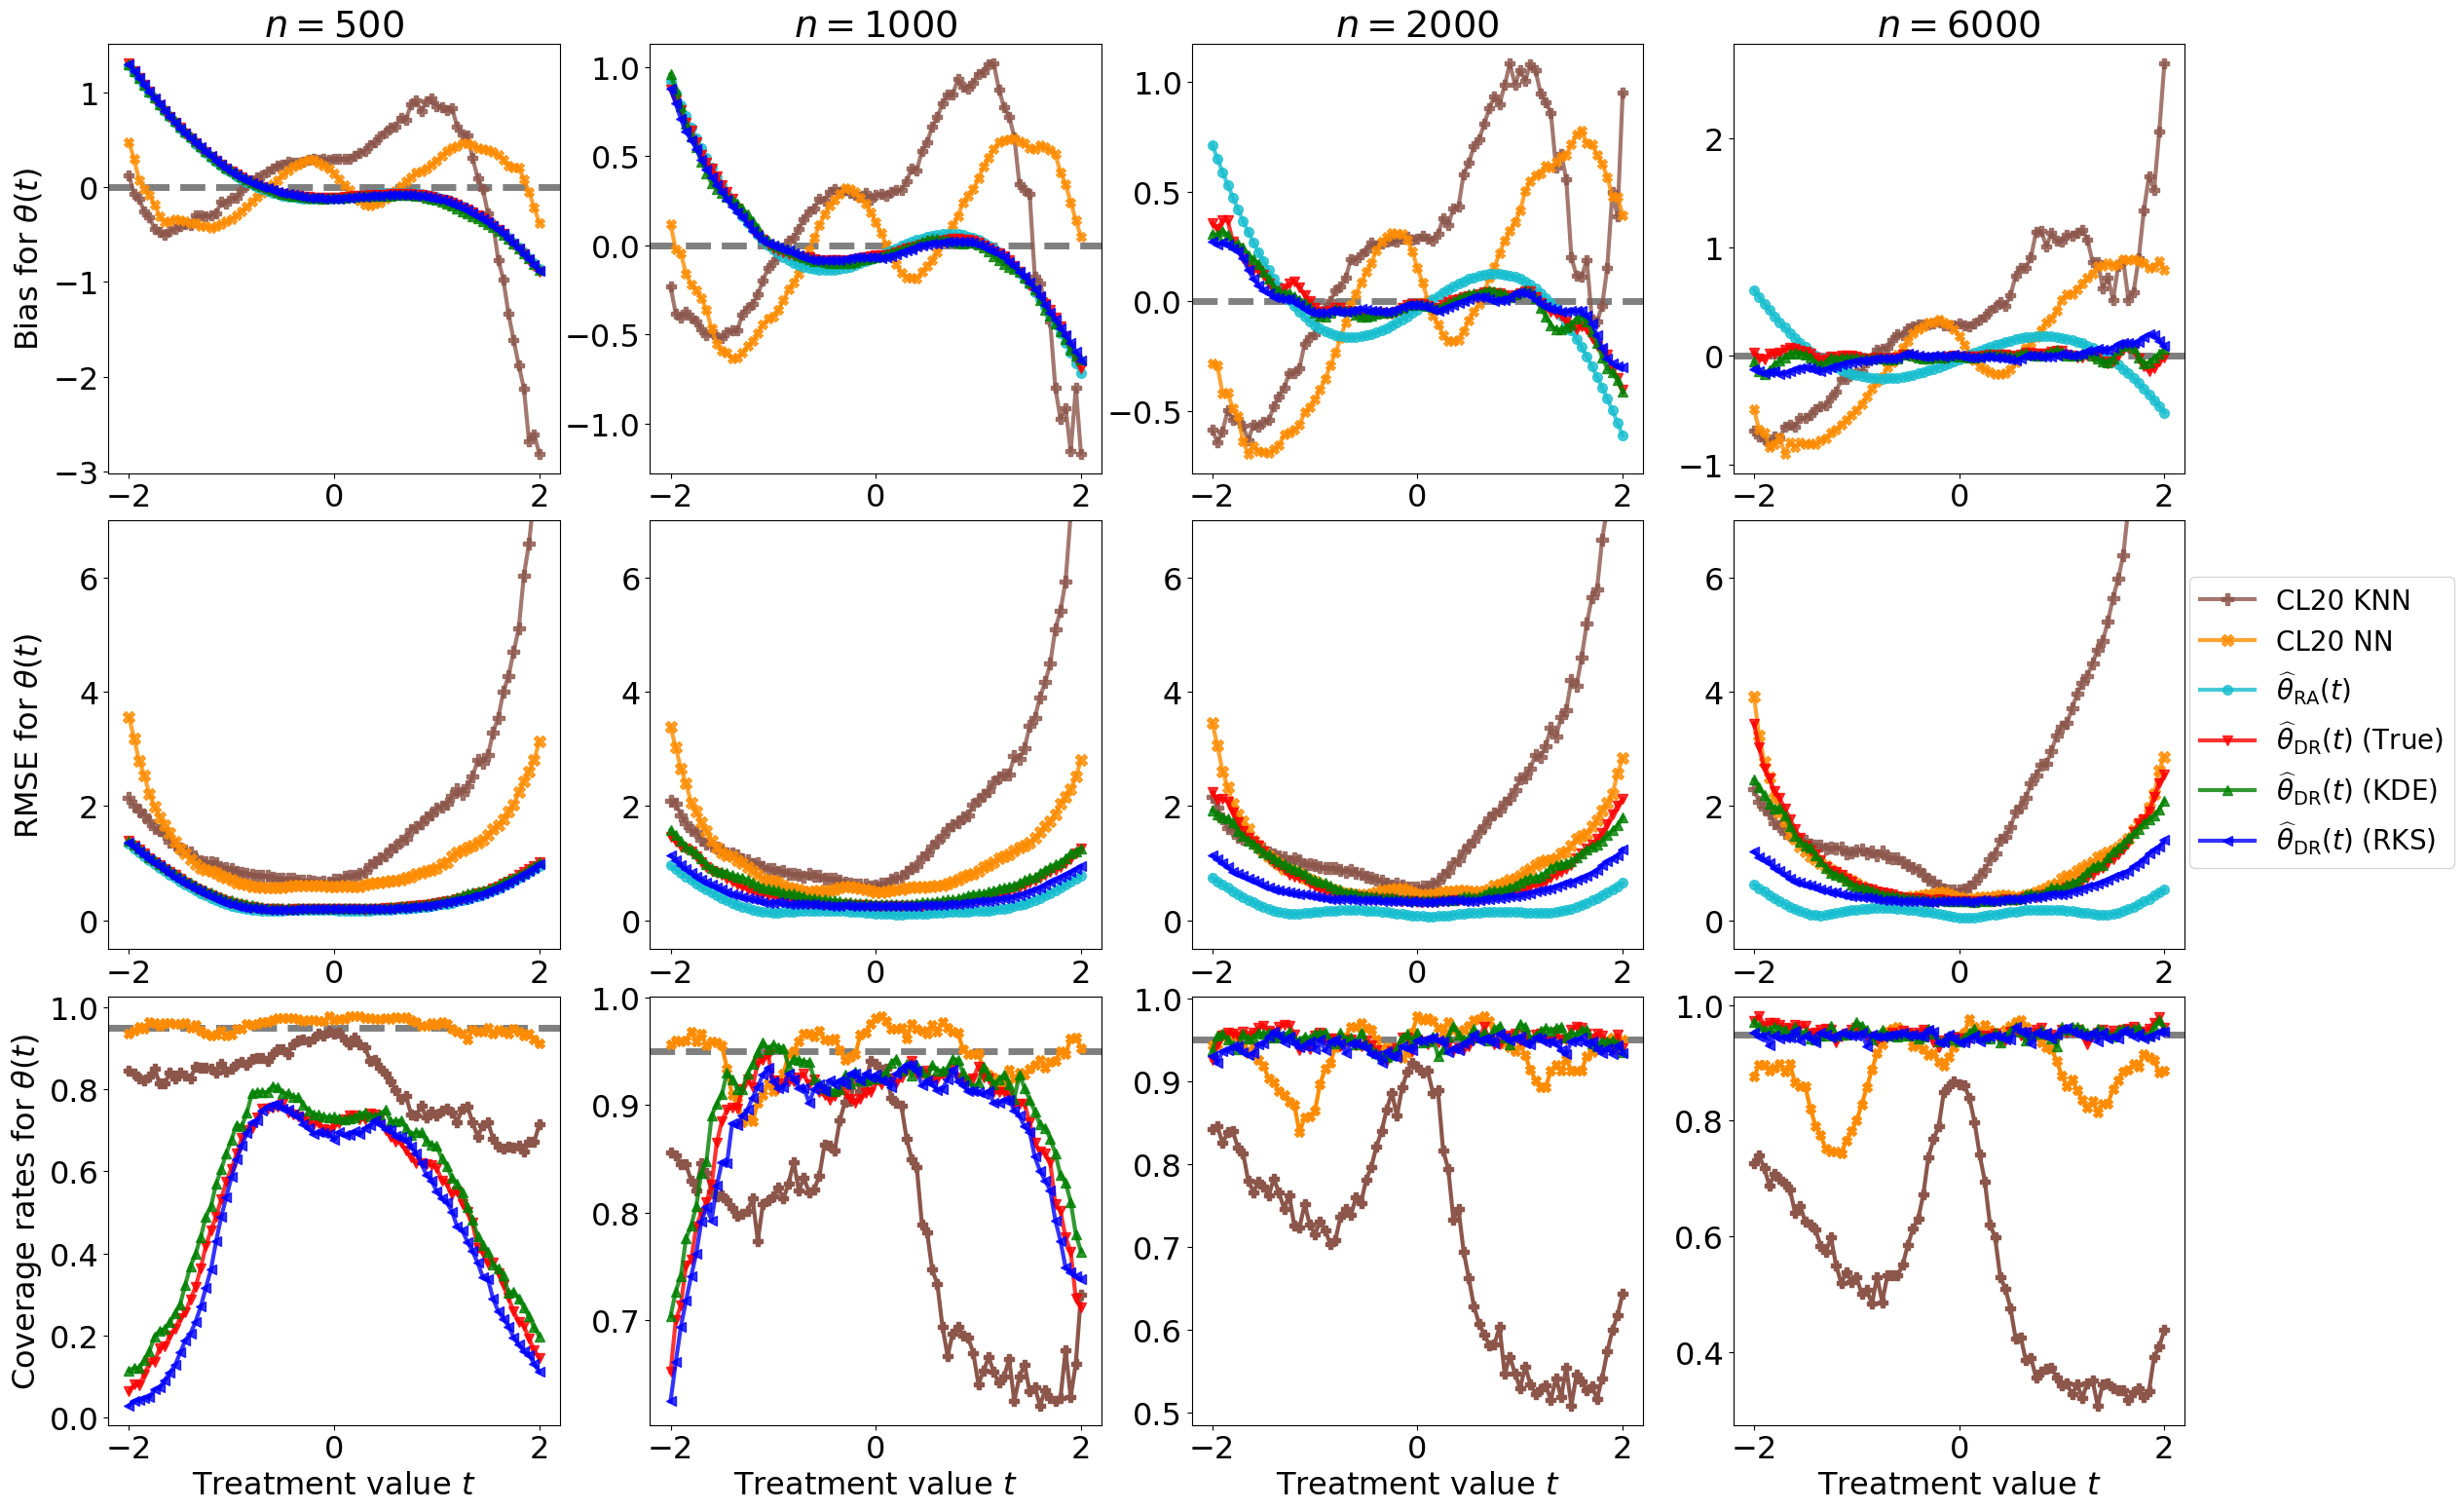

In [7]:
reg = 'NN'
fac = 1.25
cond_type = ['true', 'kde', 'reg']
t_qry = np.linspace(-2, 2, 81)
theta_true = 1.2 + 2*t_qry
n_lst = [500, 1000, 2000, 6000]

model_lst = ['knn', 'nn']

j = 0
plt.rcParams.update({'font.size': 23})
fig, ax = plt.subplots(3, 4, figsize=(26, 16))
for n in n_lst:
    for cond in cond_type:
        with open('./Syn_Results/Simulation2_theta_est_'+str(reg)+'_h'+str(fac)+'_condmod_'+str(cond)+'_n_'+str(n)+'_selfnorm.dat', "rb") as file:
            theta_ra5_lst, theta_ra1_lst, theta_ipw5_lst, theta_ipw1_lst,\
            theta_dr5_lst, sd_dr5_lst, theta_dr1_lst, sd_dr1_lst = pickle.load(file)
        
        # Bias
        theta_ra1_bias = Bias(np.array(theta_ra1_lst), theta_true)
        theta_ipw1_bias = Bias(np.array(theta_ipw1_lst), theta_true)
        theta_dr1_bias = Bias(np.array(theta_dr1_lst), theta_true)
        
        # RMSE
        theta_ra1_rmse = RMSE(np.array(theta_ra1_lst), theta_true)
        theta_ipw1_rmse = RMSE(np.array(theta_ipw1_lst), theta_true)
        theta_dr1_rmse = RMSE(np.array(theta_dr1_lst), theta_true)
        
        # Coverage
        theta_dr1_cov = CovProb(np.array(theta_dr1_lst), np.array(sd_dr1_lst), theta_true, alpha=0.95)
        
        if cond == 'true':
            res_bias = np.column_stack([t_qry, theta_ra1_bias, theta_ipw1_bias, theta_dr1_bias])
            
            res_rmse = np.column_stack([t_qry, theta_ra1_rmse, theta_ipw1_rmse, theta_dr1_rmse])
            res_cov = np.column_stack([t_qry, theta_dr1_cov])
        else:
            res_bias = np.column_stack([res_bias, theta_ipw1_bias, theta_dr1_bias])
            res_rmse = np.column_stack([res_rmse, theta_ipw1_rmse, theta_dr1_rmse])
            res_cov = np.column_stack([res_cov, theta_dr1_cov])
                                           
    
    res_bias2 = pd.DataFrame(res_bias)
    res_bias2.columns = ['Query point', 'RA', 'IPW (true)', 'DR (true)', 
                         'IPW (KDE)', 'DR (KDE)', 'IPW (reg)', 'DR (reg)']
    
    res_rmse2 = pd.DataFrame(res_rmse)
    res_rmse2.columns = ['Query point', 'RA', 'IPW (true)', 'DR (true)', 
                         'IPW (KDE)', 'DR (KDE)', 'IPW (reg)', 'DR (reg)']
    
    res_cov2 = pd.DataFrame(res_cov)
    res_cov2.columns = ['Query point', 'DR (true)', 'DR (KDE)', 'DR (reg)']
    
    for ml in model_lst:
        with open('./Syn_Results/Sim2_Replicate_est_'+str(ml)+'_h'+str(fac)+'_n_'+str(n)+'.dat', "rb") as file:
            m_est1_lst, m_std1_lst, theta_est1_lst, theta_std1_lst,\
            m_est5_lst, m_std5_lst, theta_est5_lst, theta_std5_lst = pickle.load(file)
        
        theta1_bias = Bias(np.array(theta_est1_lst), theta_true)
        theta1_rmse = RMSE(np.array(theta_est1_lst), theta_true)
        
        theta1_cov = CovProb(np.array(theta_est1_lst), np.array(theta_std1_lst), theta_true, alpha=0.95)
        
        if ml == 'knn':
            res_bias_rep = np.column_stack([t_qry, theta1_bias])
            res_rmse_rep = np.column_stack([t_qry, theta1_rmse])
            res_cov_rep = np.column_stack([t_qry, theta1_cov])
        else:
            res_bias_rep = np.column_stack([res_bias_rep, theta1_bias])
            res_rmse_rep = np.column_stack([res_rmse_rep, theta1_rmse])
            res_cov_rep = np.column_stack([res_cov_rep, theta1_cov])
        
    res_bias2_rep = pd.DataFrame(res_bias_rep)
    res_bias2_rep.columns = ['Query point', 'CL20 KNN', 'CL20 NN']
    
    res_rmse2_rep = pd.DataFrame(res_rmse_rep)
    res_rmse2_rep.columns = ['Query point', 'CL20 KNN', 'CL20 NN']
    
    res_cov2_rep = pd.DataFrame(res_cov_rep)
    res_cov2_rep.columns = ['Query point', 'CL20 KNN', 'CL20 NN']
    
    res_bias2 = res_bias2[['Query point', 'RA', 'DR (true)', 'DR (KDE)', 'DR (reg)']]
    res_rmse2 = res_rmse2[['Query point', 'RA', 'DR (true)', 'DR (KDE)', 'DR (reg)']]
    
    # Plotting bias
    ax[0][j].axhline(y=0, color='black', linestyle='dashed', linewidth=5, alpha=0.5)
    col_lst = ['tab:cyan', 'red', 'green', 'blue']
    col_lab = [r'$\widehat{\theta}_{\mathrm{RA}}(t)$', r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (True)', 
               r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (KDE)', r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS)']
    mark_lst = ["o", "v", "^", "<", "P", "X"]
    col_lst2 = ['tab:brown', 'darkorange']
    for i in range(res_bias2_rep.shape[1] - 1):
        ax[0][j].plot(t_qry, res_bias2_rep.iloc[:,i+1], markersize=7, linewidth=3, marker=mark_lst[i+4], 
                      label=res_bias2_rep.columns[i+1], color=col_lst2[i], alpha=0.8)
    for i in range(res_bias2.shape[1] - 1):
        ax[0][j].plot(t_qry, res_bias2.iloc[:,i+1], markersize=7, linewidth=3, marker=mark_lst[i], 
                      label=col_lab[i], color=col_lst[i], alpha=0.8)
    # ax[0][j].set_xlabel(r'Query point $T=t$')
    ax[0][0].set_ylabel(r'Bias for $\theta(t)$')
    ax[0][j].set_title(r'$n=$'+str(n))
    # ax[0][3].legend(bbox_to_anchor=(1, 0.9))
    
    # Plotting RMSE
    for i in range(res_rmse2_rep.shape[1] - 1):
        ax[1][j].plot(t_qry, res_rmse2_rep.iloc[:,i+1], linewidth=3, markersize=8, marker=mark_lst[i+4], 
                      label=res_rmse2_rep.columns[i+1], color=col_lst2[i], alpha=0.8)
    for i in range(res_rmse2.shape[1] - 1):
        ax[1][j].plot(t_qry, res_rmse2.iloc[:,i+1], linewidth=3, markersize=7, marker=mark_lst[i], 
                      label=col_lab[i], color=col_lst[i], alpha=0.8)
    # ax[1][j].set_xlabel(r'Query point $T=t$')
    ax[1][j].set_ylim([-0.5, 7])
    ax[1][0].set_ylabel(r'RMSE for $\theta(t)$')
    ax[1][3].legend(bbox_to_anchor=(0.98, 0.9), fontsize=20)
    
    # Plotting Coverage
    ax[2][j].axhline(y=0.95, color='black', linestyle='dashed', linewidth=5, alpha=0.5, label='Nominal level')
    for i in range(res_cov2_rep.shape[1] - 1):
        ax[2][j].plot(t_qry, res_cov2_rep.iloc[:,i+1], linewidth=3, markersize=7, marker=mark_lst[i+4], 
                      label=res_cov2_rep.columns[i+1], color=col_lst2[i])
    for i in range(res_cov2.shape[1] - 1):
        ax[2][j].plot(t_qry, res_cov2.iloc[:,i+1], linewidth=3, markersize=7, marker=mark_lst[i+1], 
                      label=col_lab[i+1], color=col_lst[i+1], alpha=0.8)
    ax[2][j].set_xlabel(r'Treatment value $t$')
    ax[2][0].set_ylabel(r'Coverage rates for $\theta(t)$')
    # ax[2][j].set_ylim([0.56, 1])
    # ax[2][3].legend(bbox_to_anchor=(1, 0.9))
    
    j += 1
fig.align_ylabels()
fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.11)
fig.savefig('./Figures/theta_L1_selfnorm_diffn.pdf')